In [3]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full

import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re

from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm
import json
from utils import *
from help import *

/cbica/home/dadashkj/neurite/neurite/__init__.py:33: FutureWarning: The default backend will soon be changing to 'pytorch'. If you prefer to use TensorFlow, please set the NEURITE_BACKEND environment variable to 'tensorflow'.
  backend = py.utils.get_backend()
/cbica/home/dadashkj/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ghost = sf.load_volume("/gpfs/fs001/cbica/home/afreens/PIG_TBI/ATLASES/ghost.nii.gz").resize(0.2).reshape((512,512,512))
atlas = sf.load_volume("/gpfs/fs001/cbica/home/afreens/PIG_TBI/ATLASES/atlas.nii.gz").resize(0.2).reshape((512,512,512))

label_maps=[np.array(ghost),np.array(atlas),np.array(ghost)]

[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


3
[0.2 0.2 0.2]


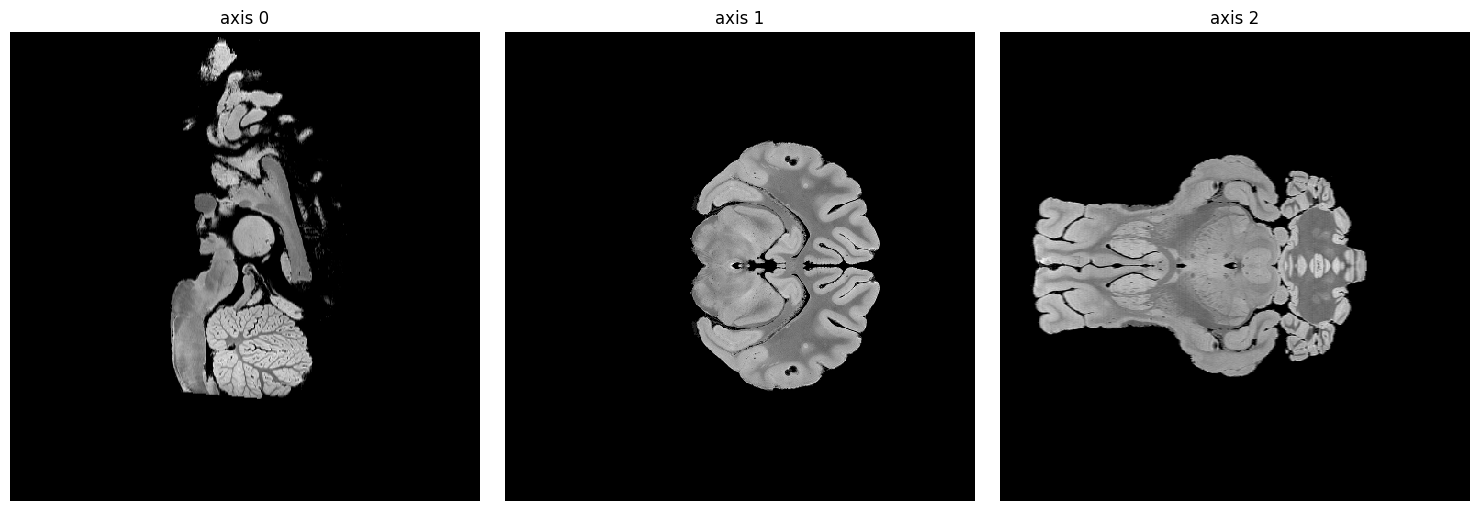

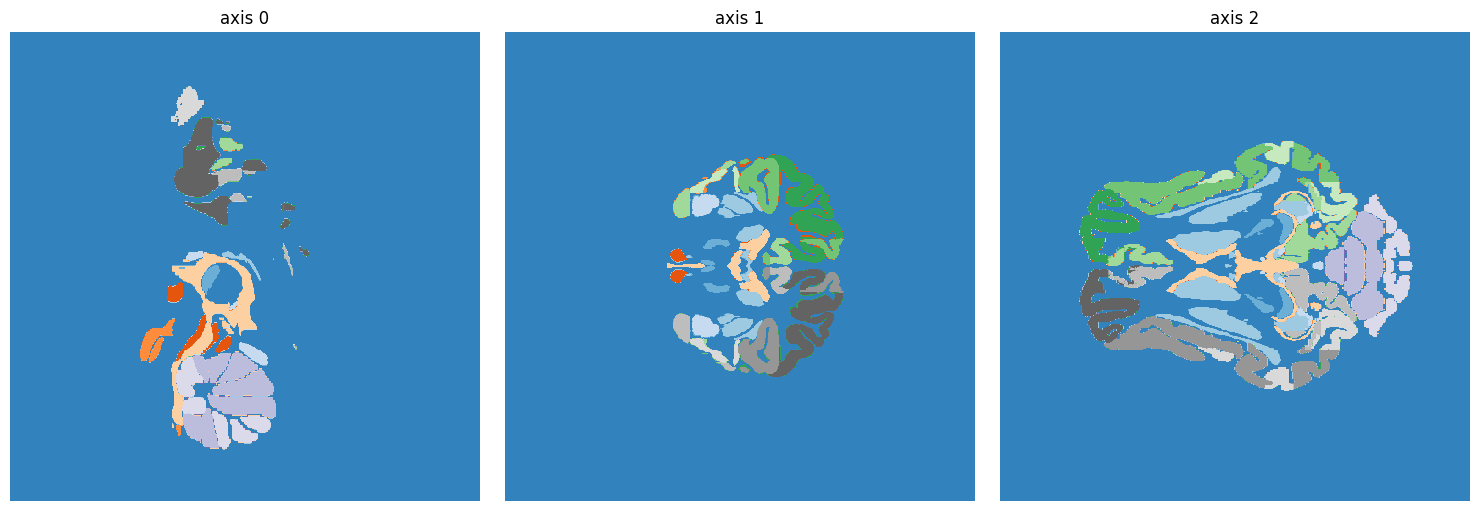

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [49]:
print(len(label_maps))
print(ghost.geom.voxsize)
ne.plot.volume3D(ghost)
ne.plot.volume3D(atlas,cmaps=['tab20c'])

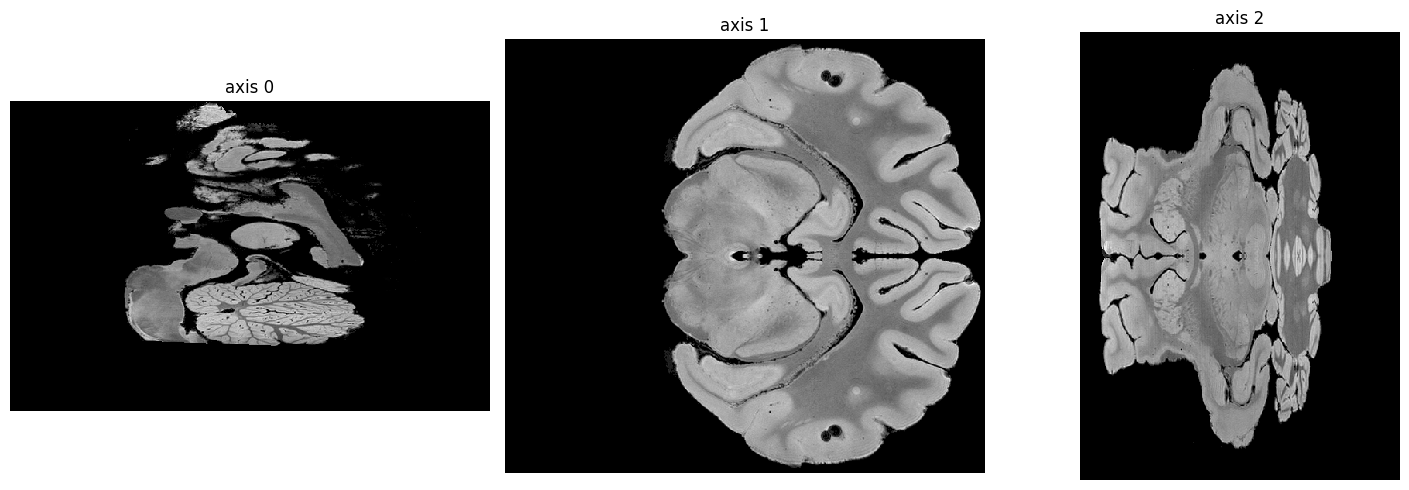

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [19]:
ne.plot.volume3D(ghost)

In [20]:
affine_ = a.geom.vox2world

In [14]:
np.array(affine_)

array([[ -0.1       ,   0.        ,   0.        ,  27.95000076],
       [  0.        ,  -0.25      ,   0.        ,  49.875     ],
       [  0.        ,   0.        ,   0.1       , -30.95000076],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [21]:
nib.save(nib.Nifti1Image(a, np.array(affine_)),os.path.join("synth_data", 'pig_anat.nii.gz'))


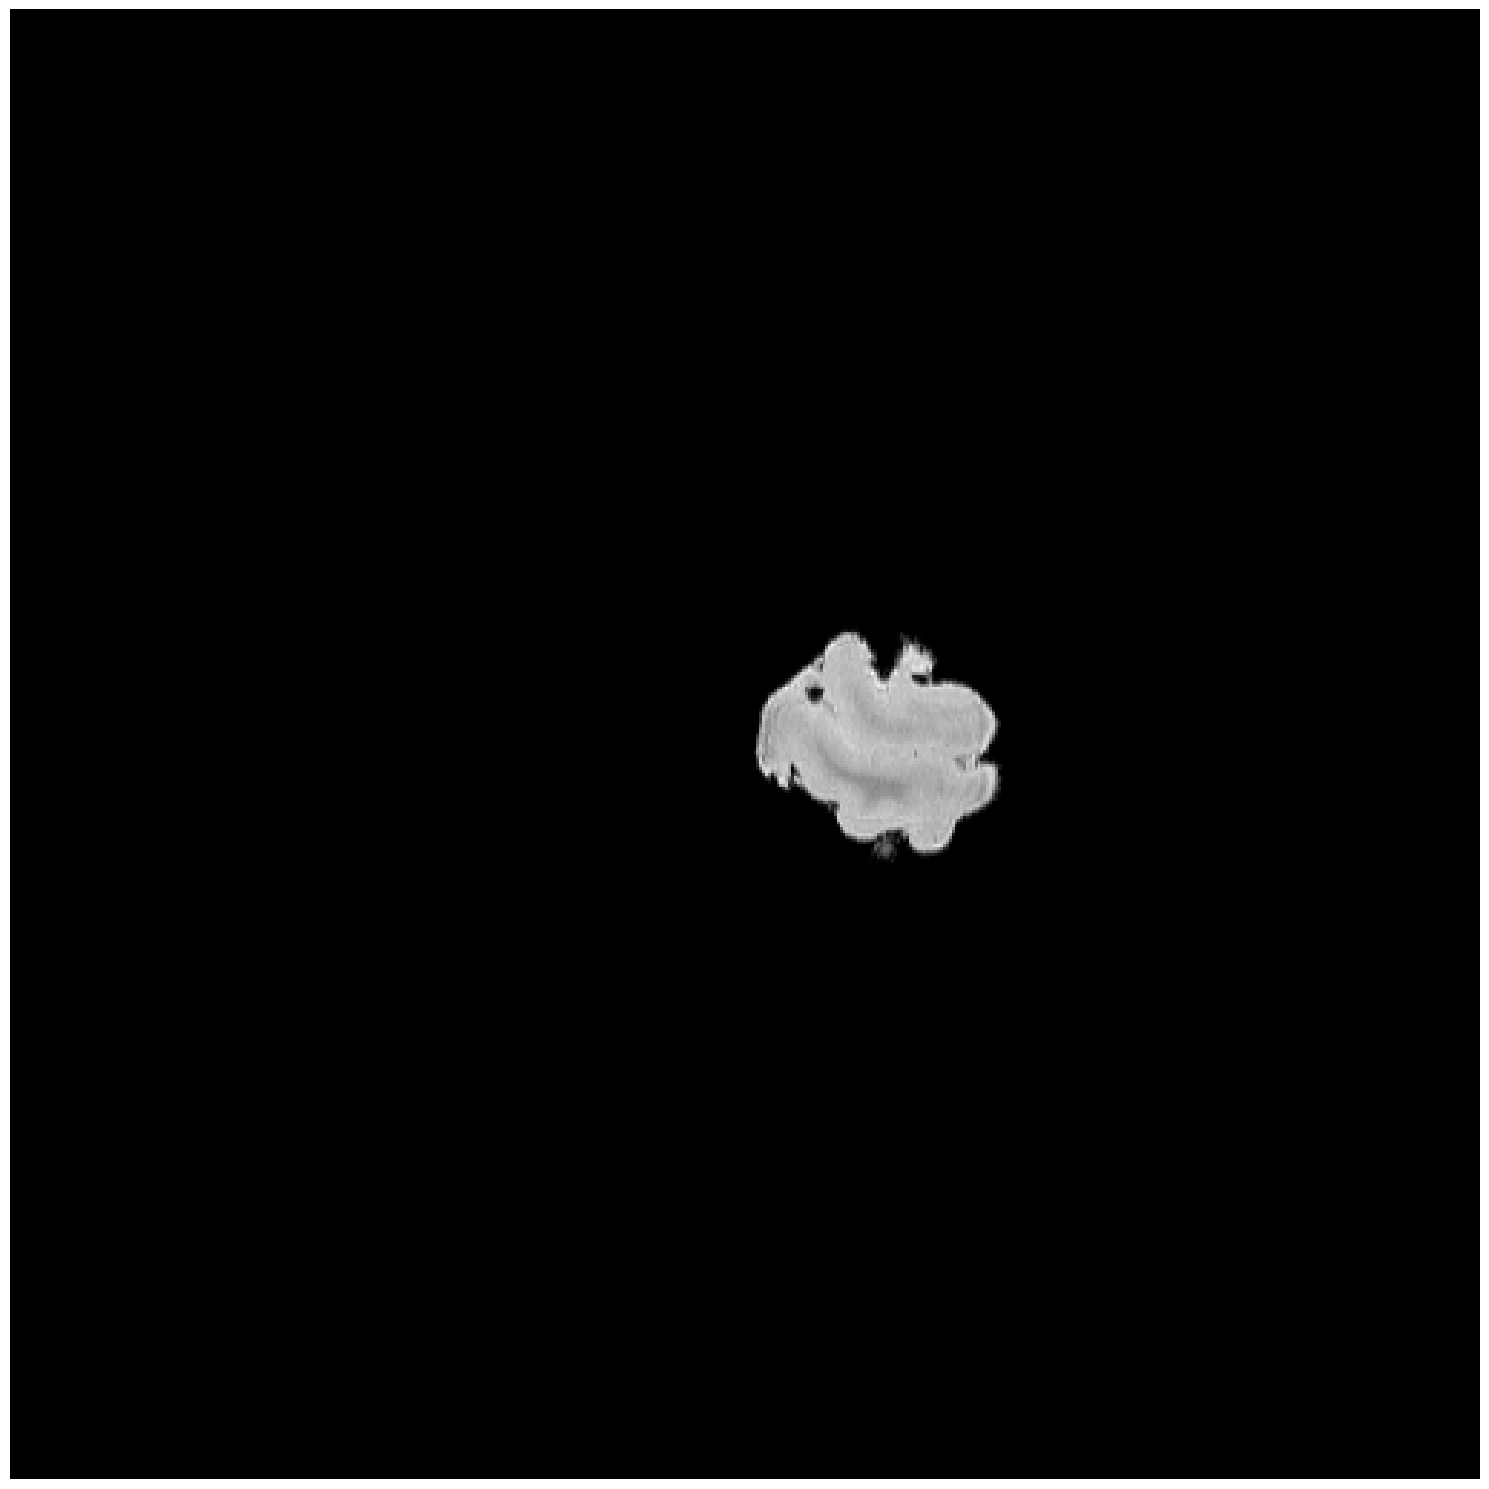

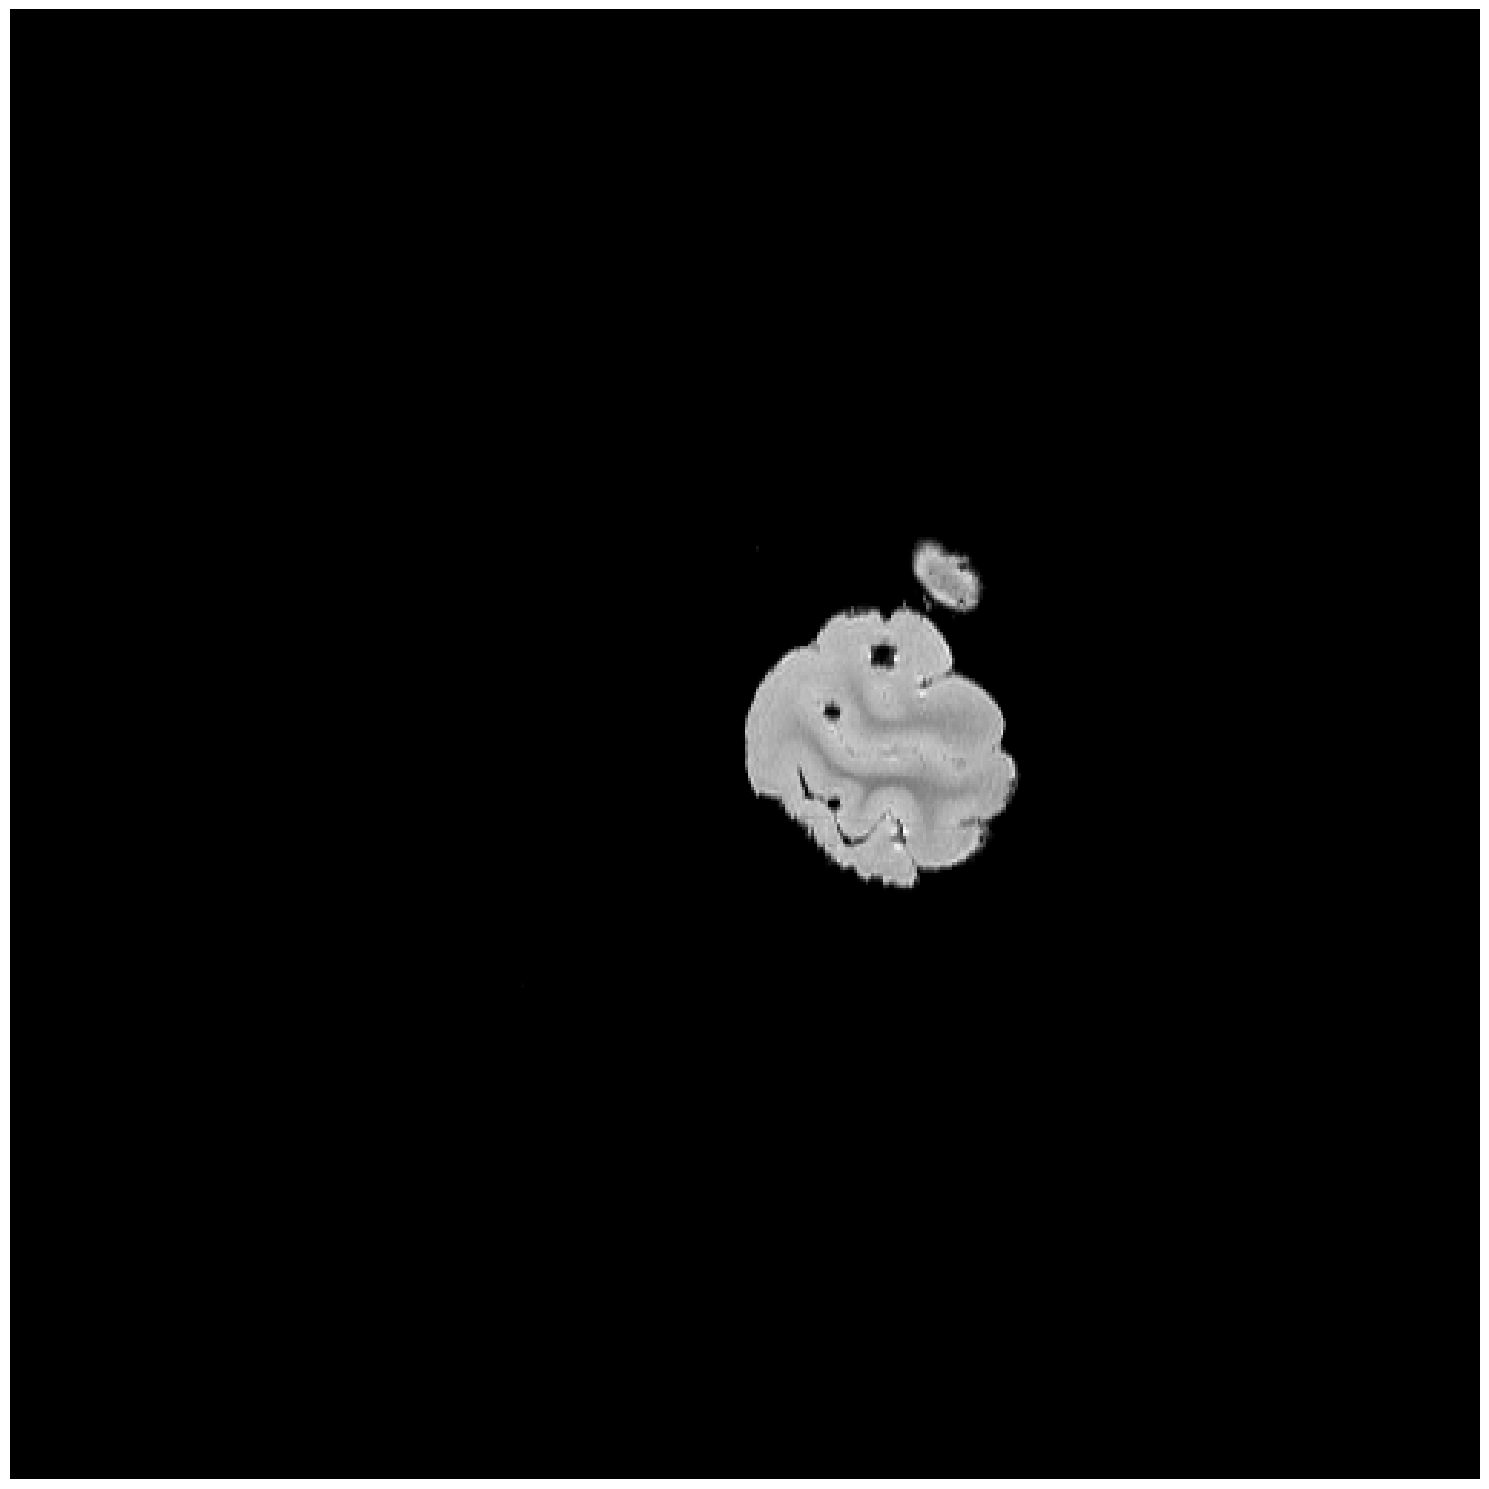

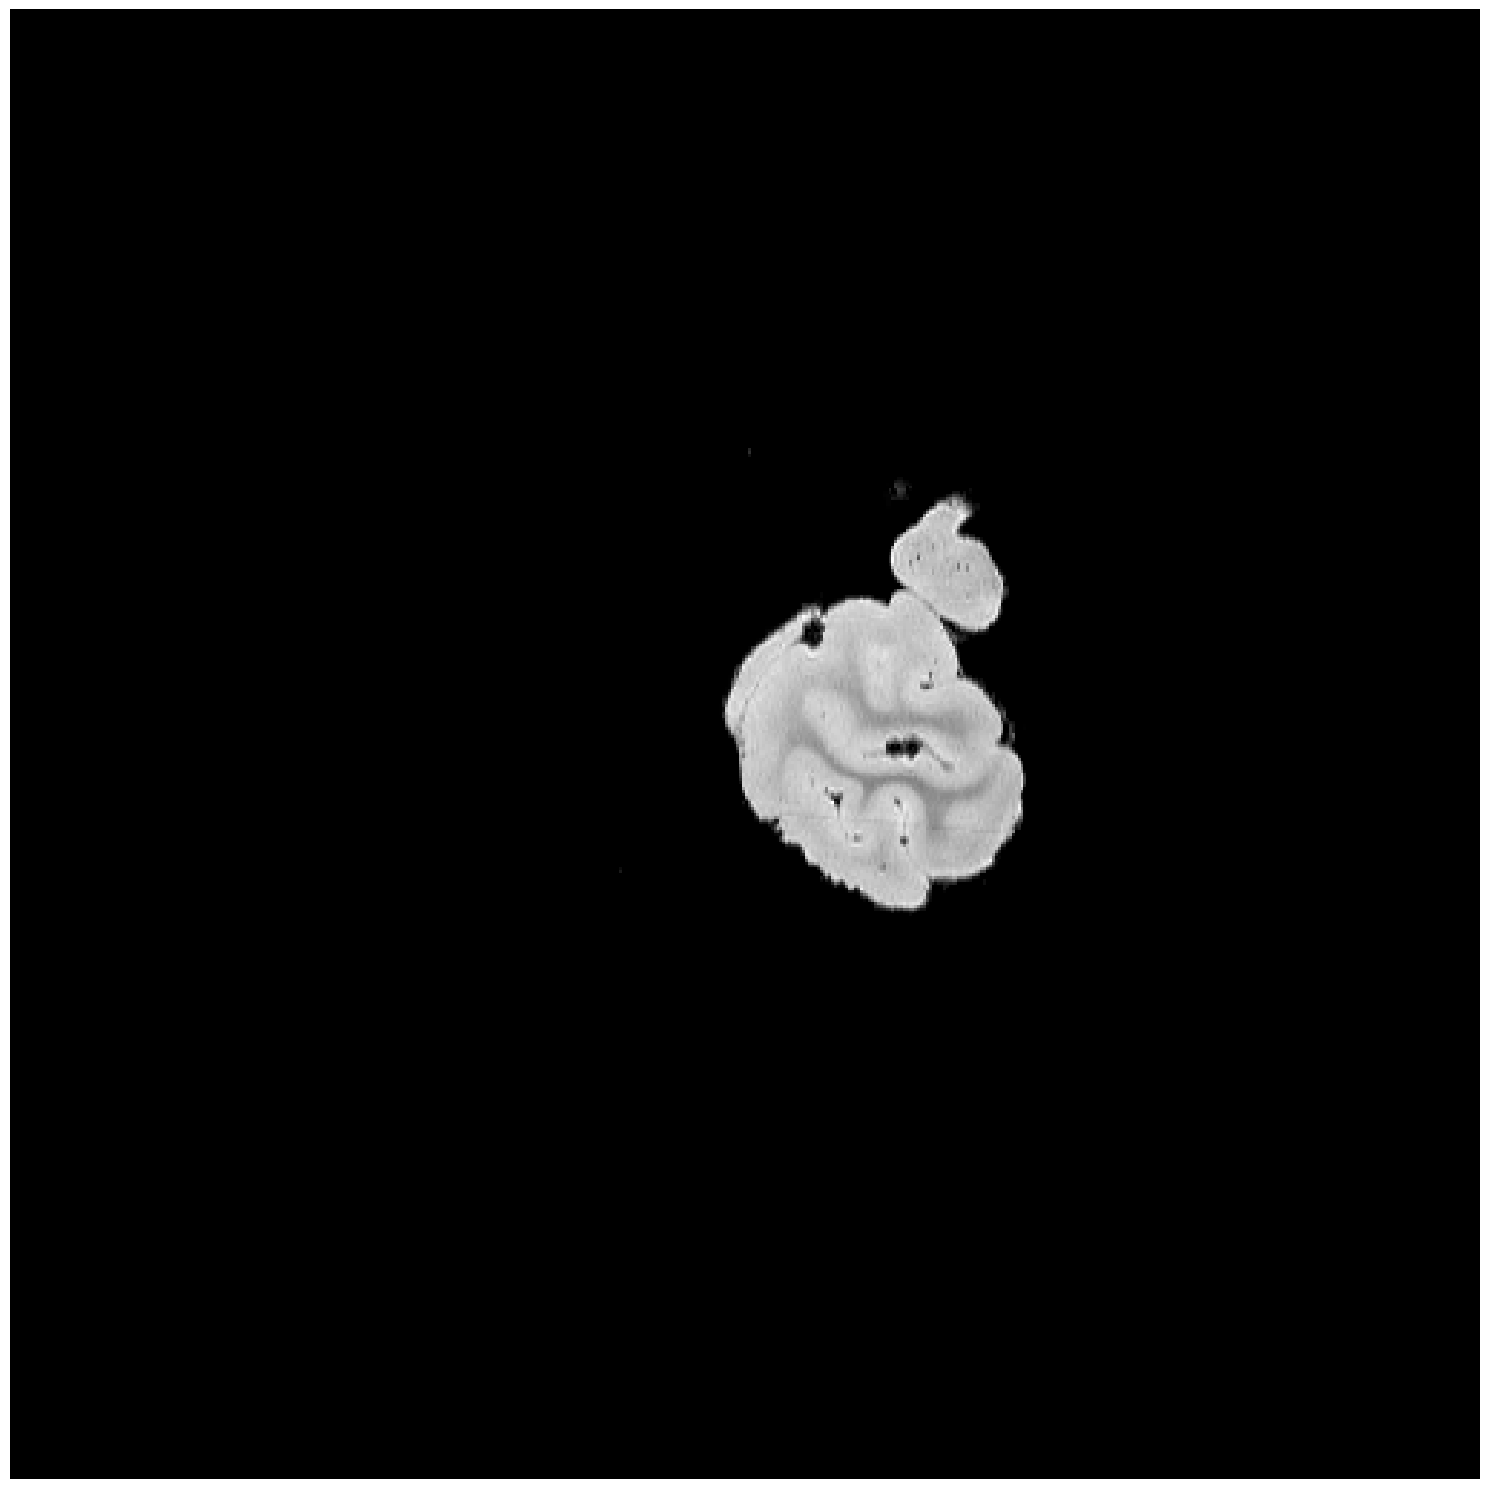

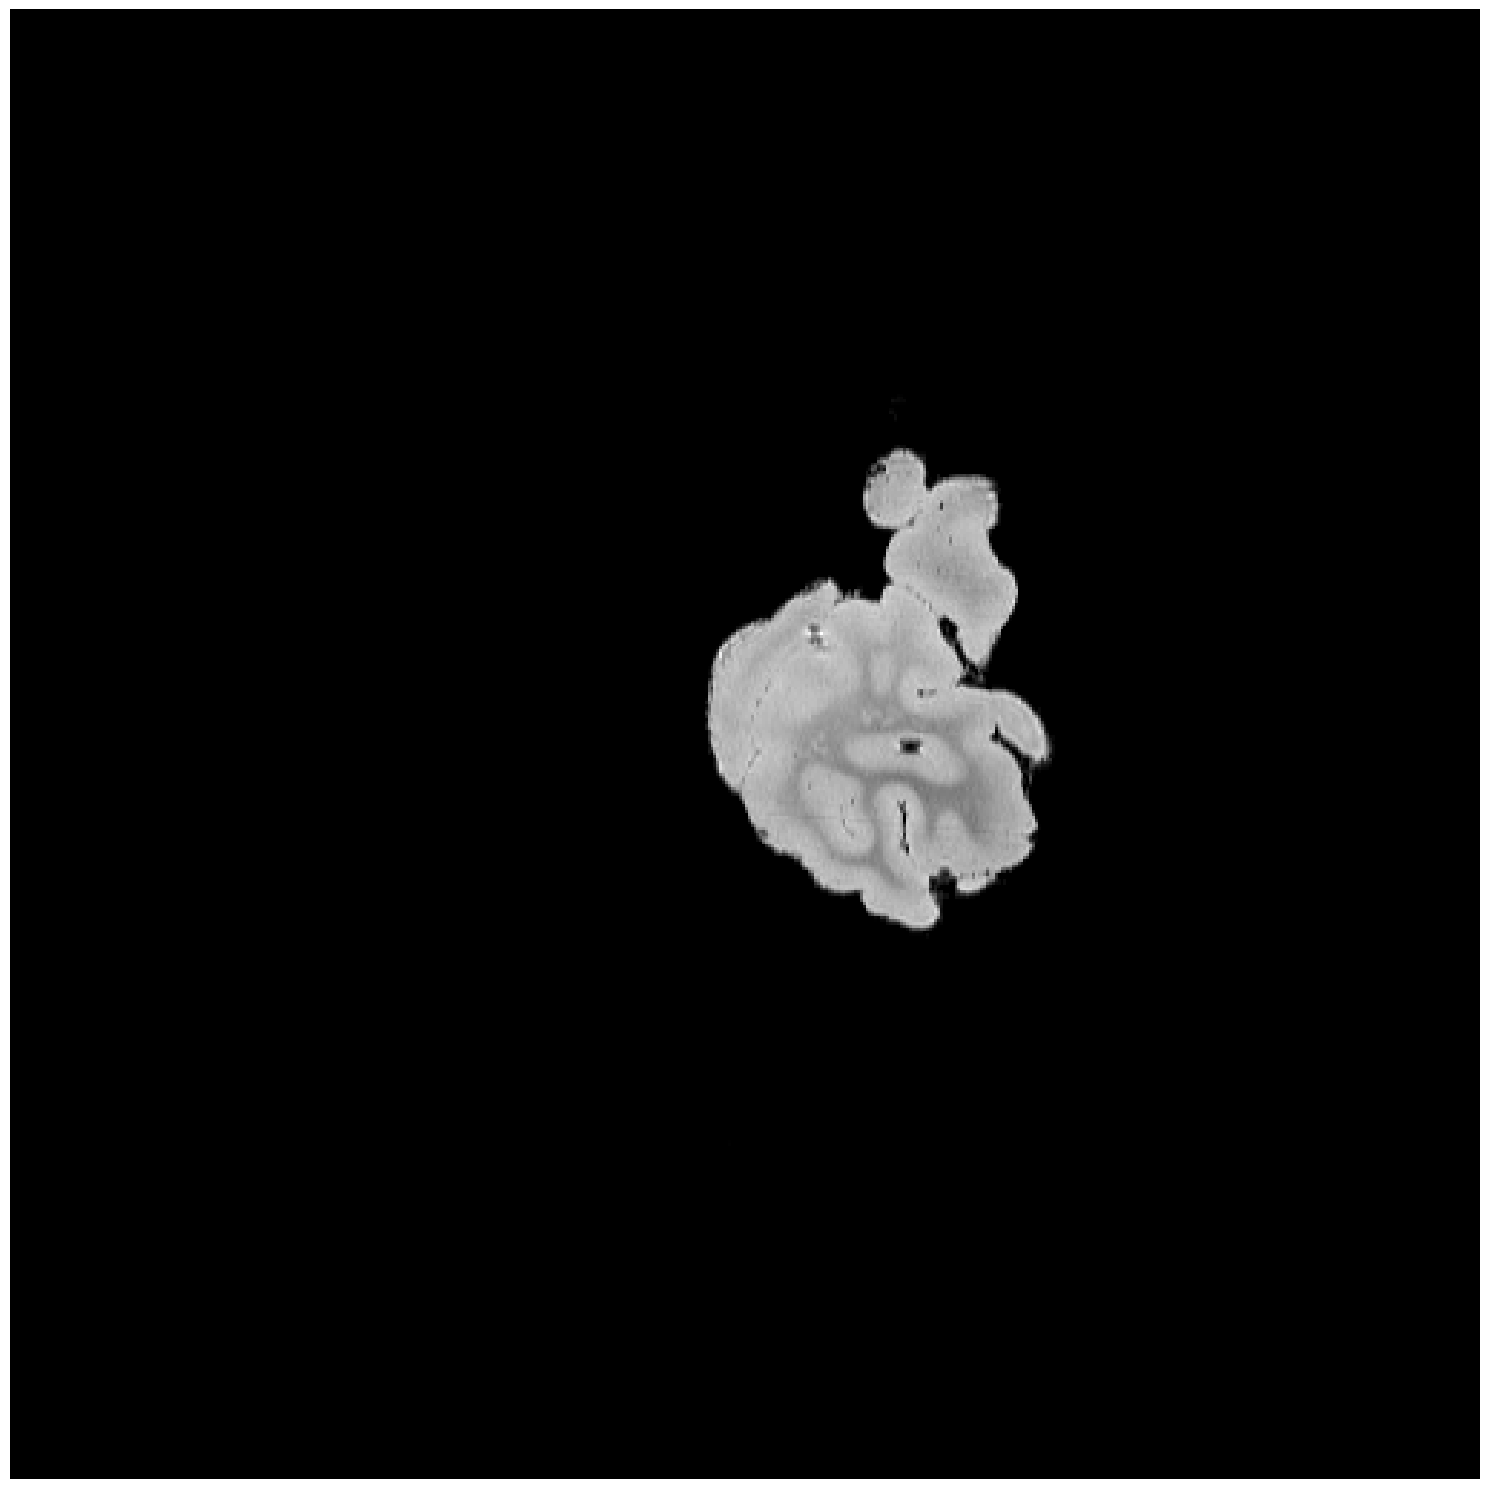

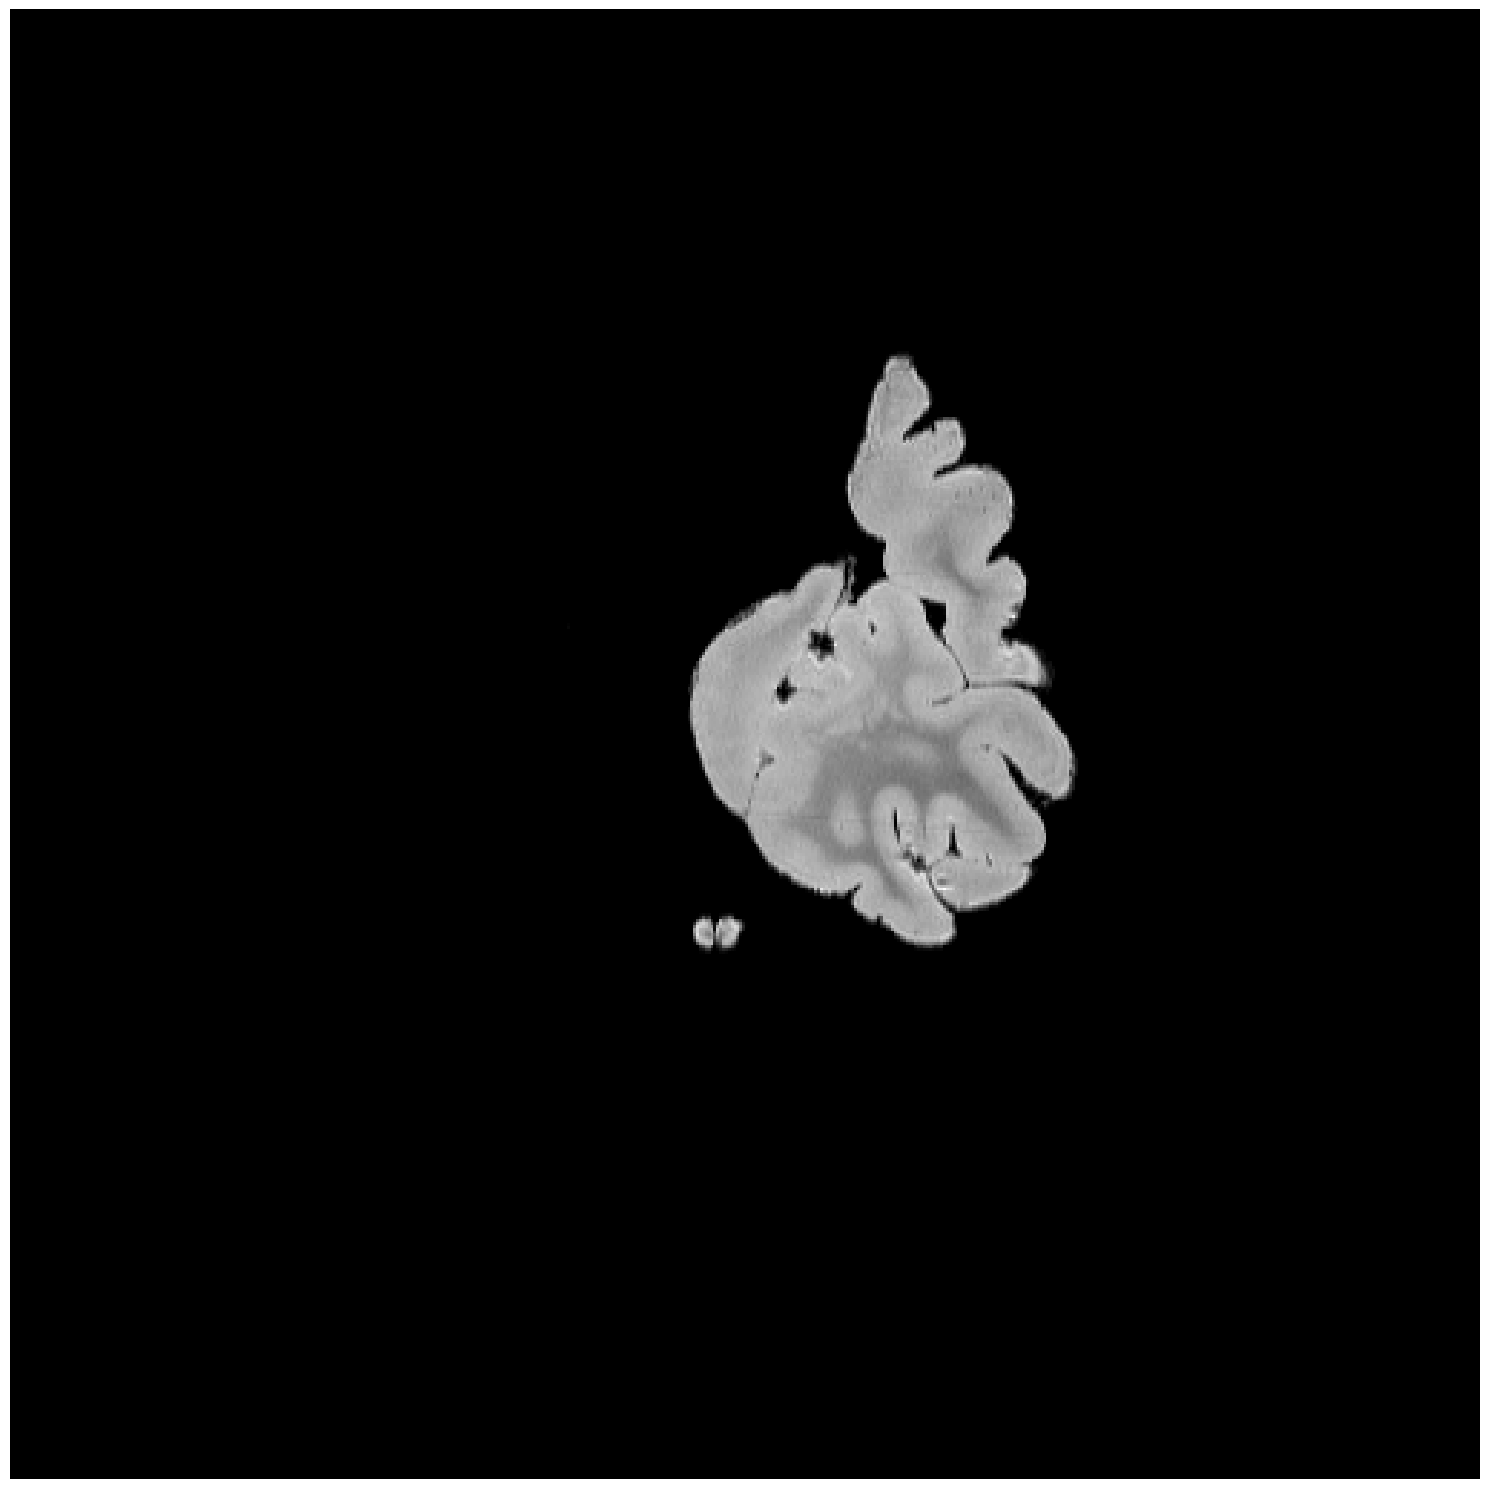

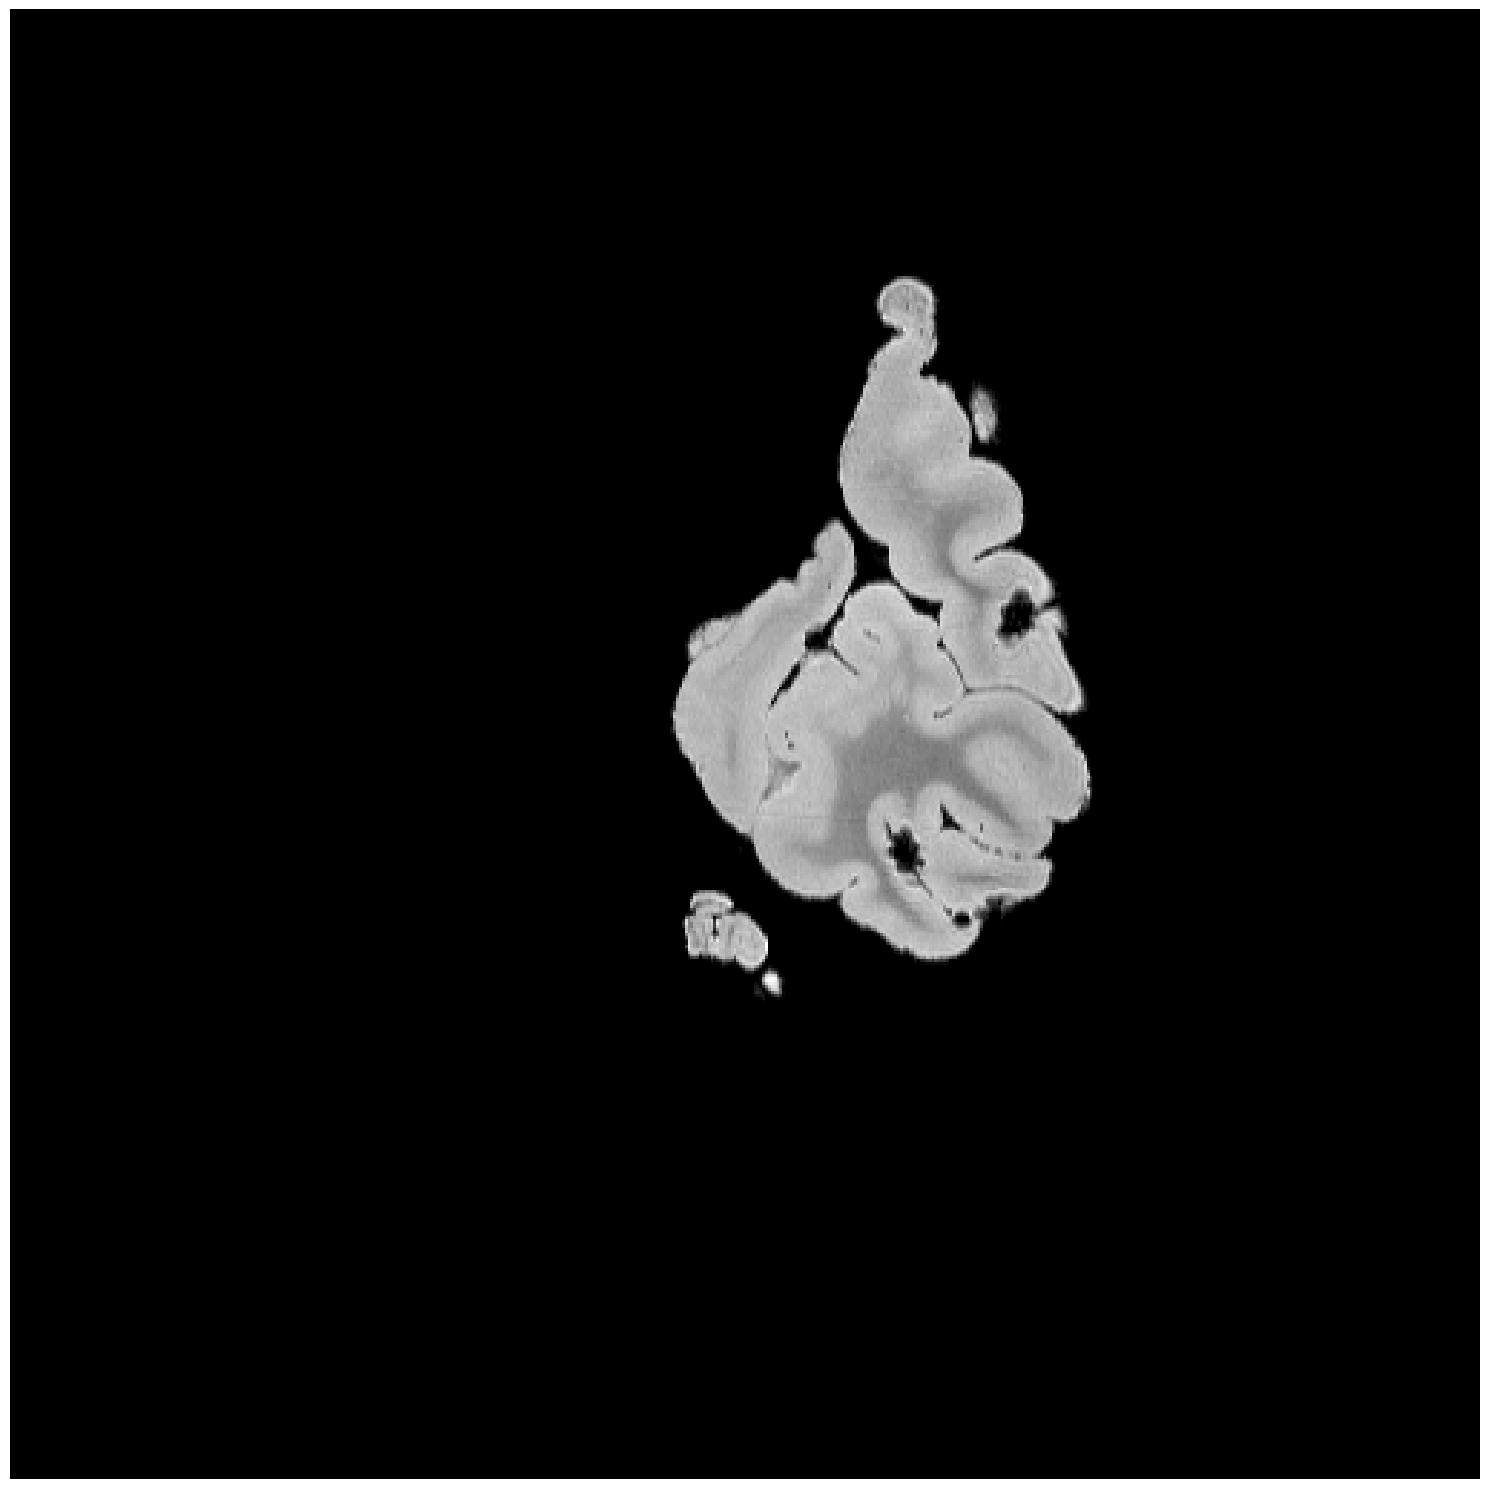

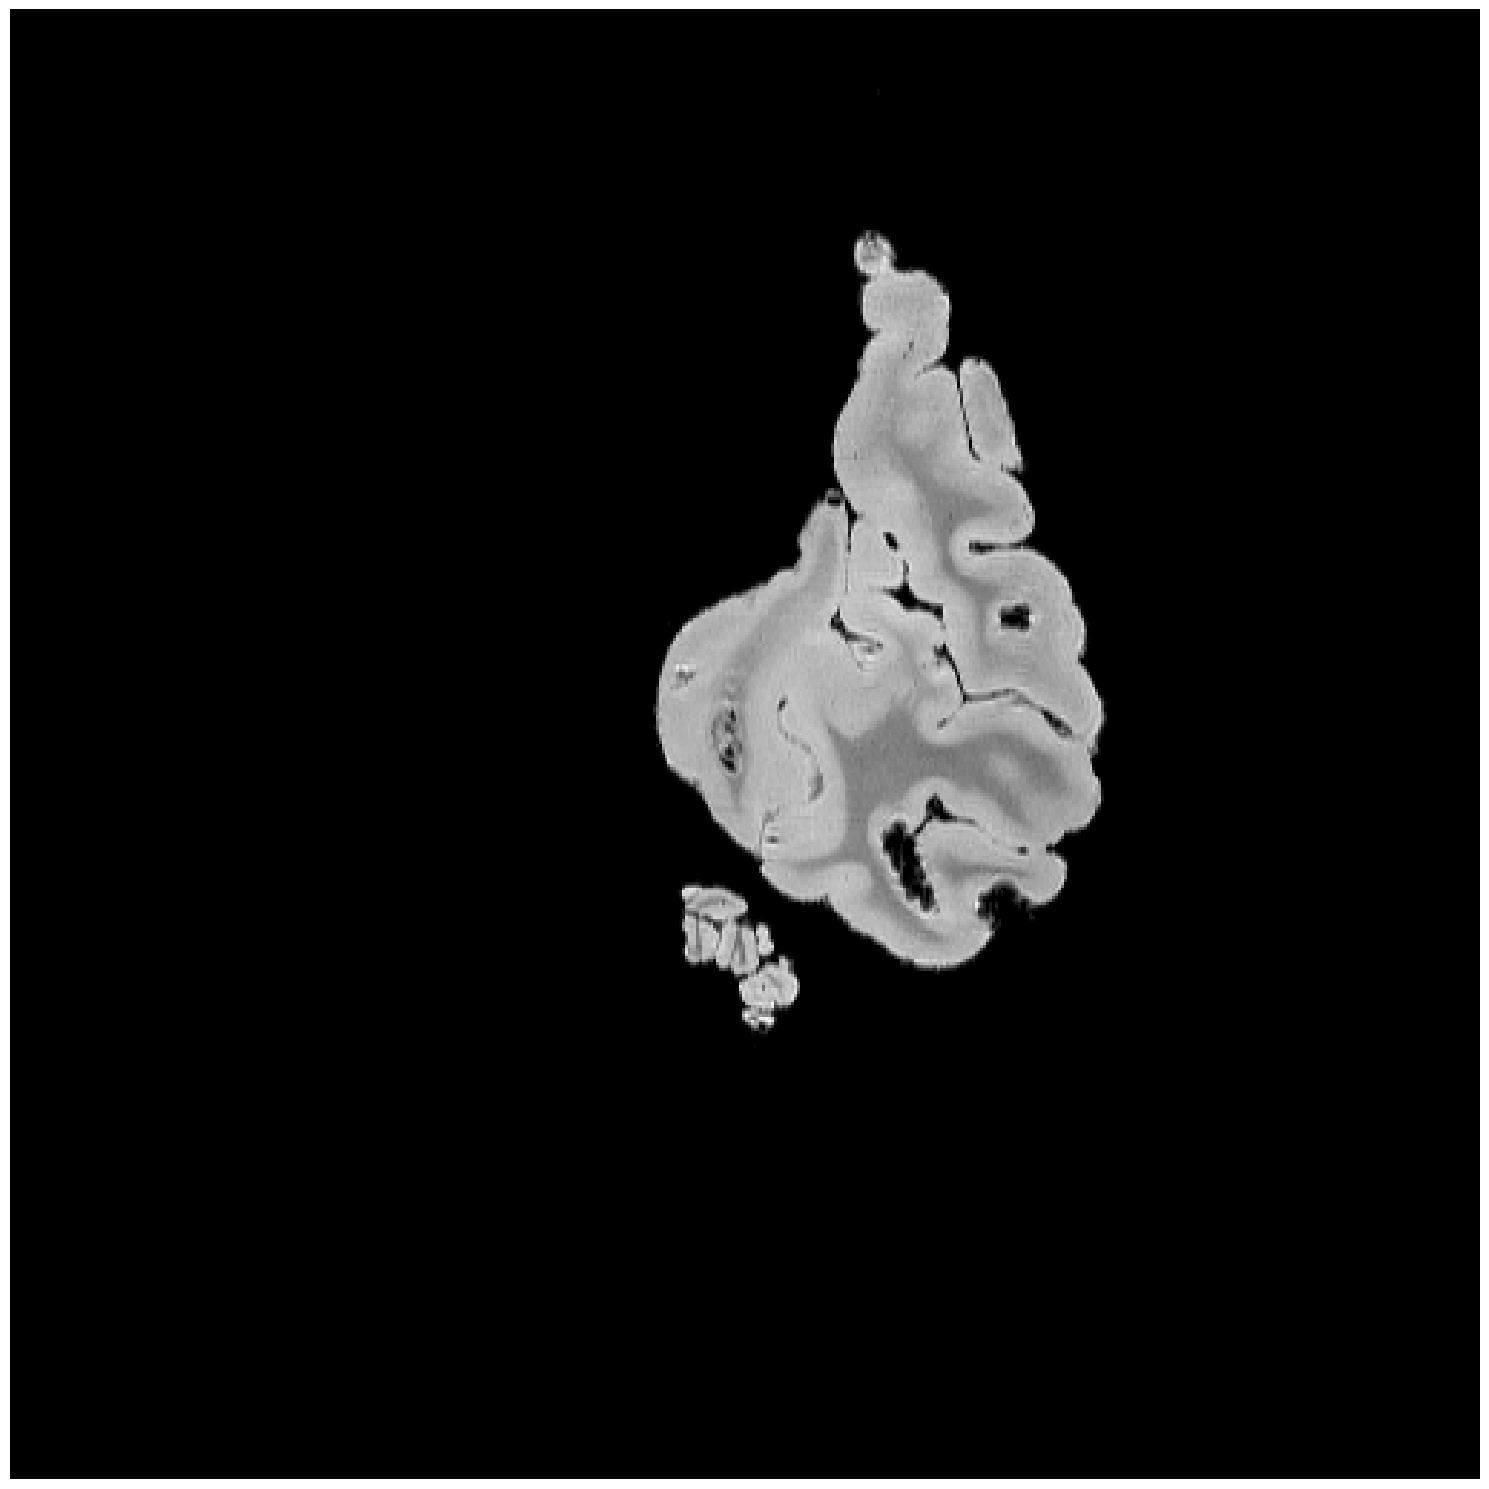

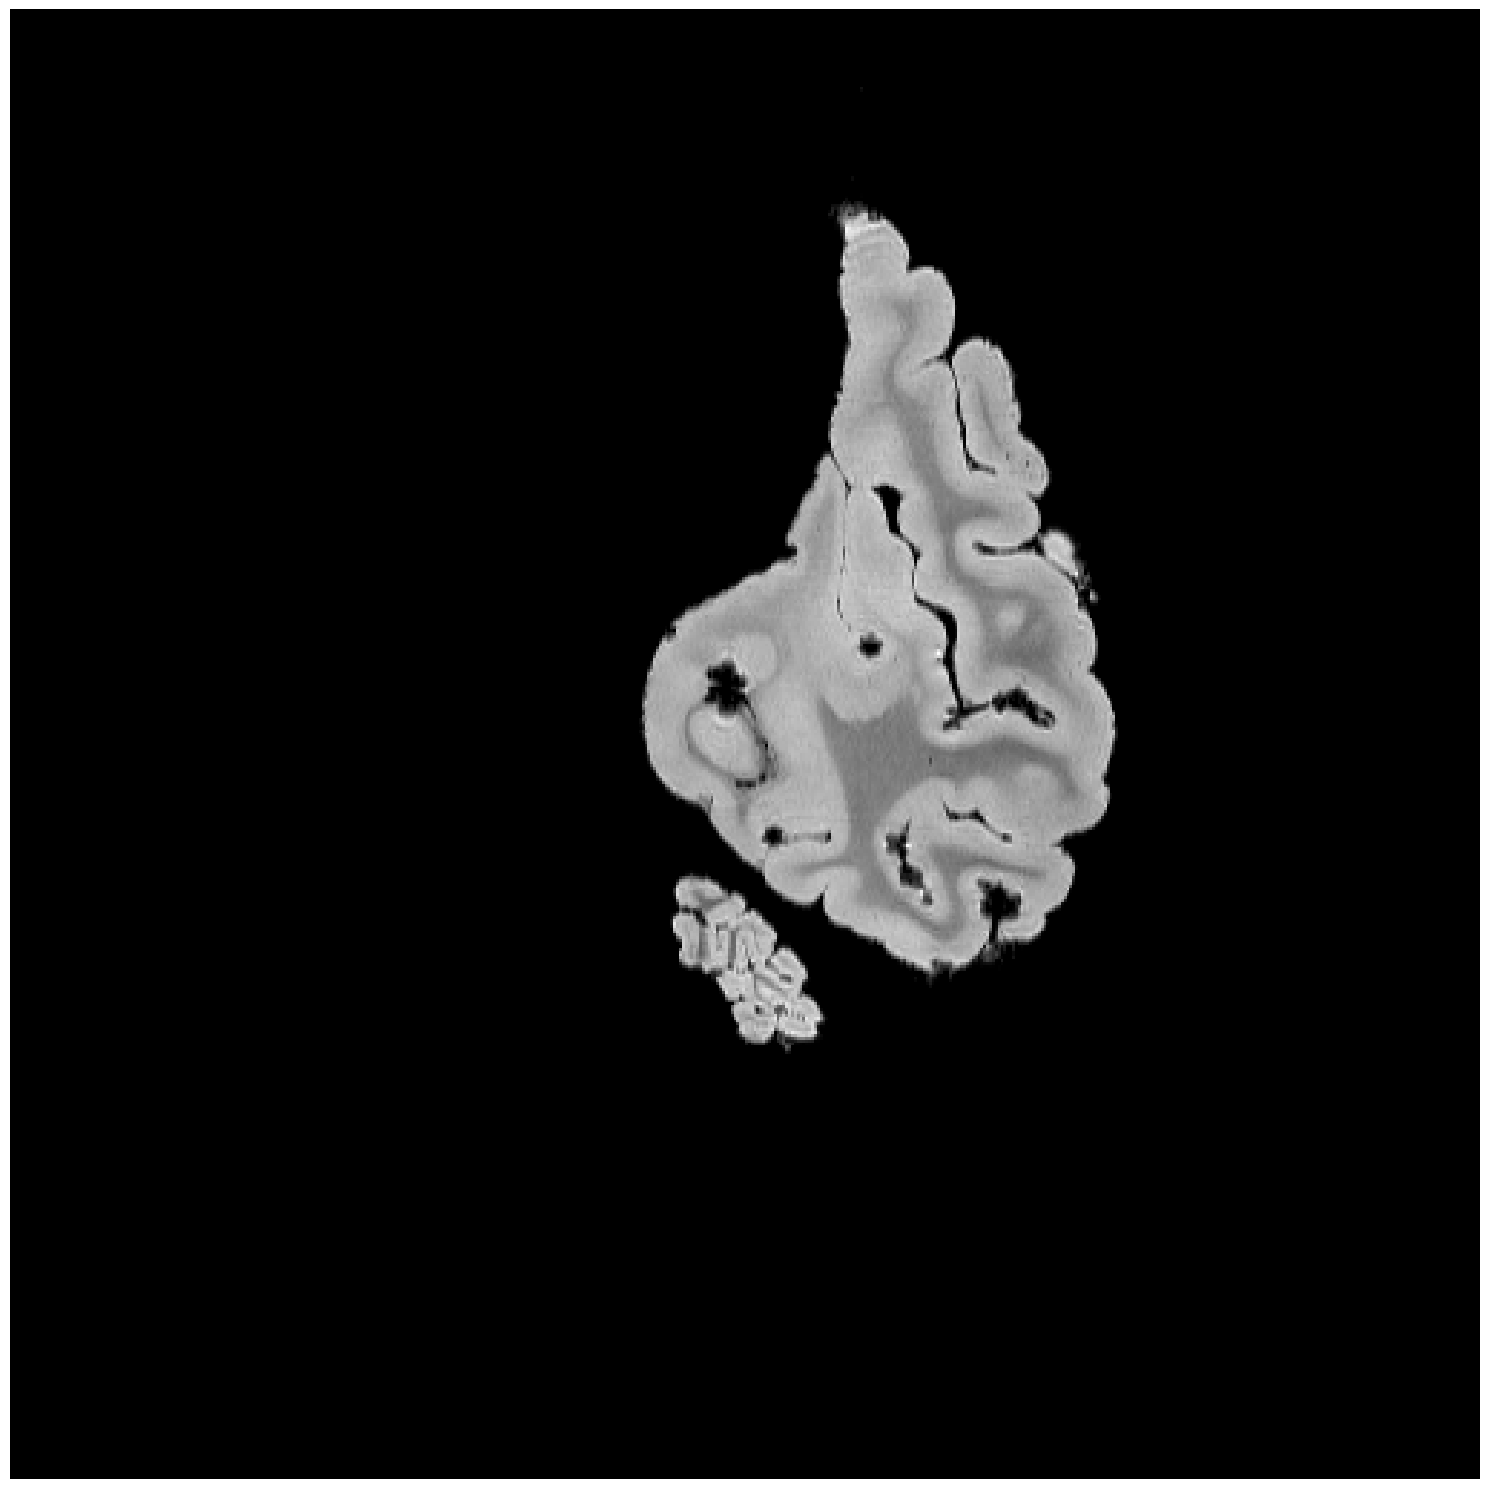

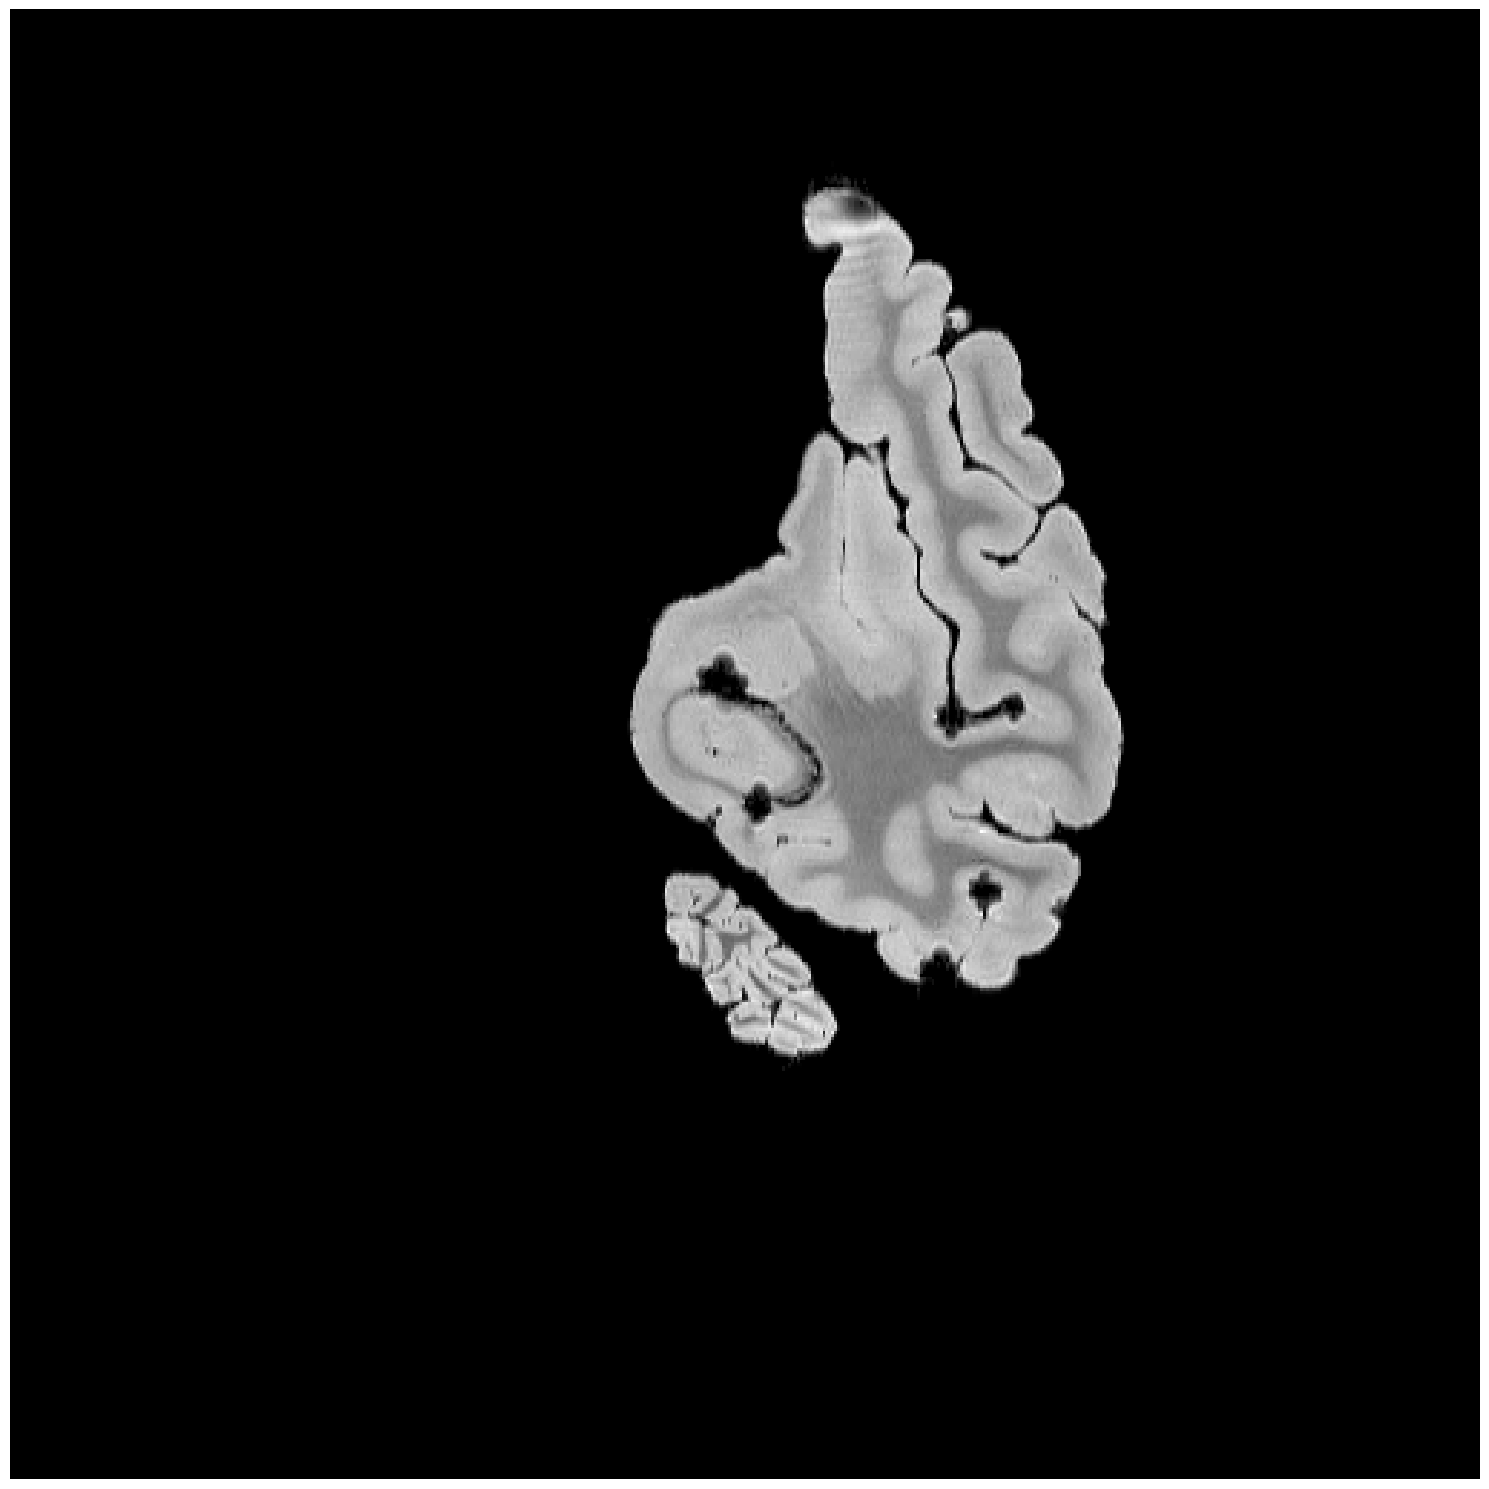

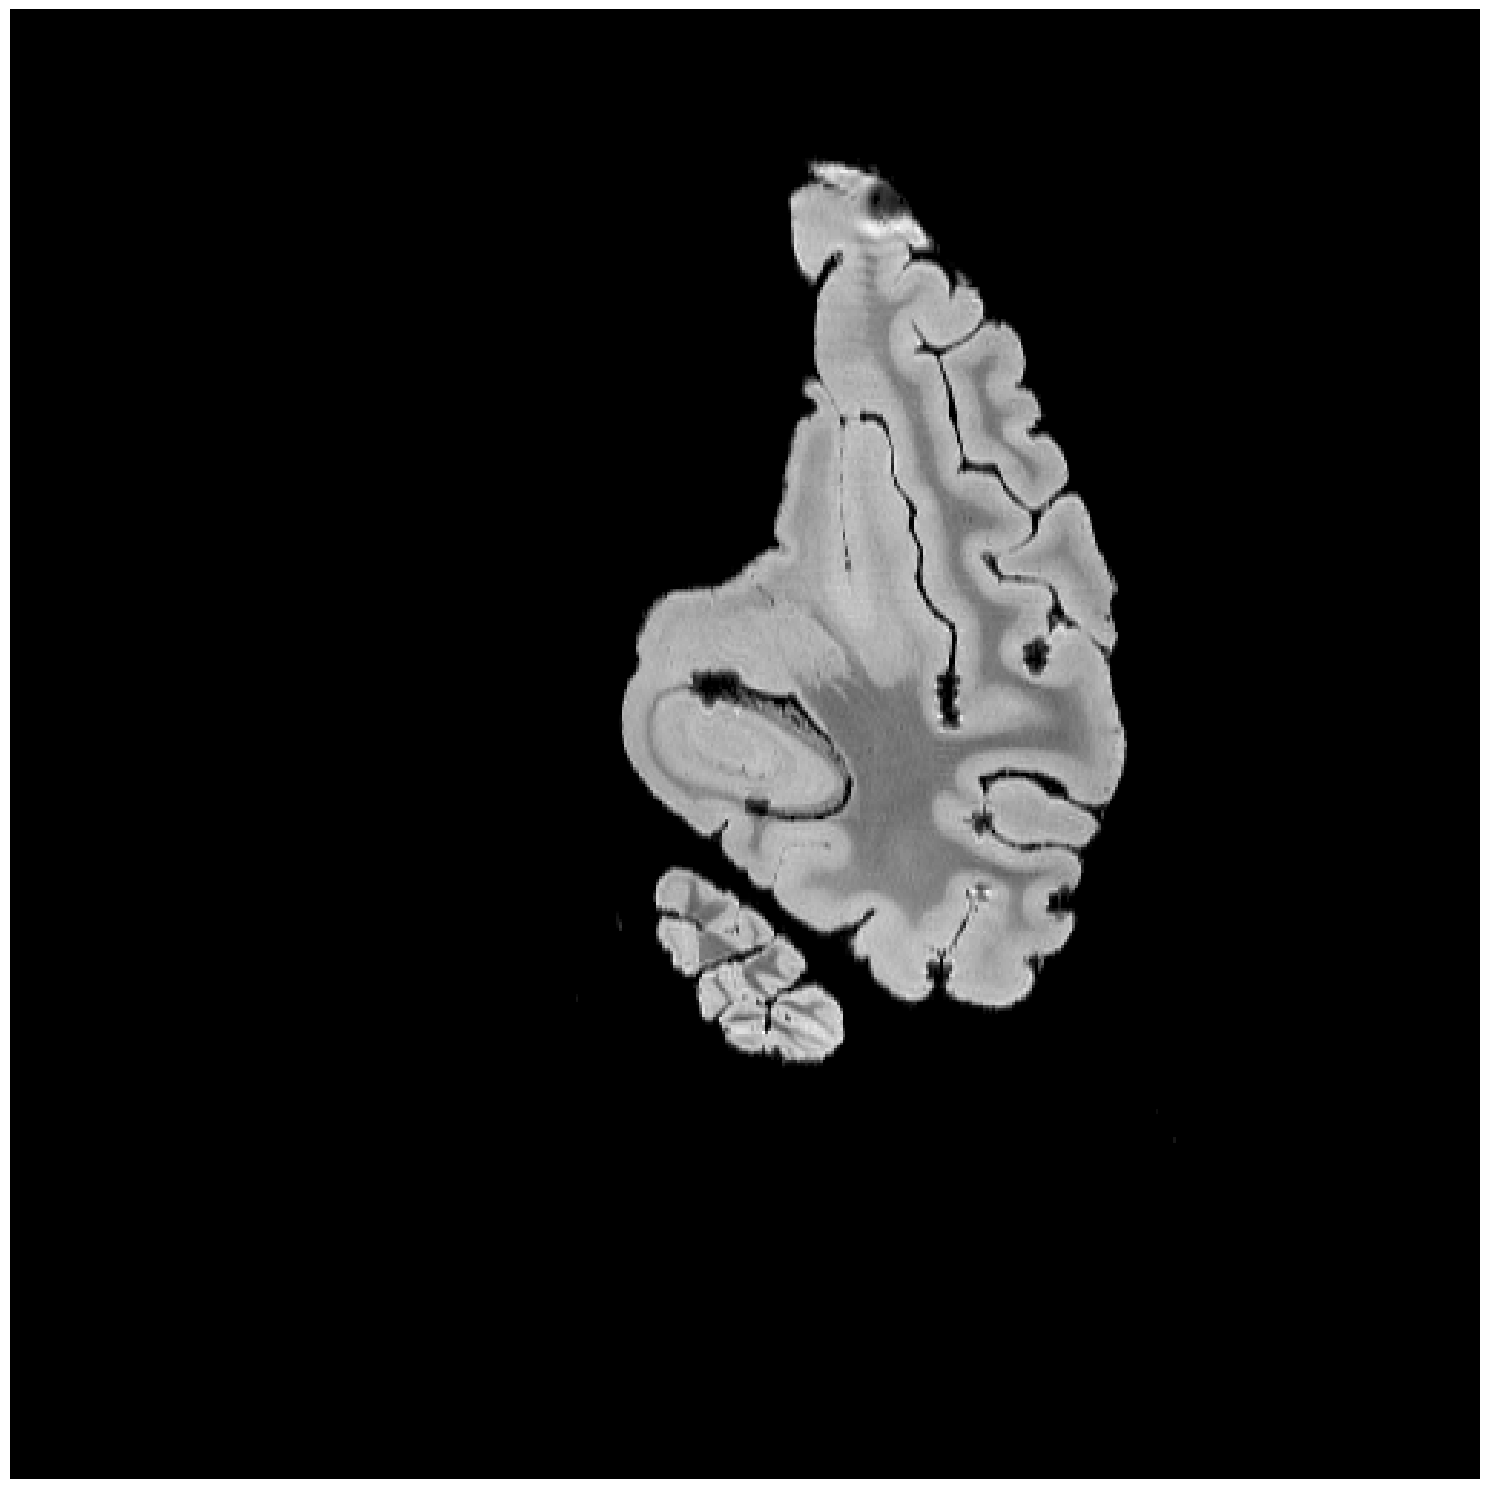

In [11]:
ghost = np.asarray(ghost)
for i in range(130,180,5):
    ne.plot.slices(ghost[i,:,:],cmaps=['gray'])

In [50]:
def generator_Sadia_Net(label_maps,img_size):
    rand = np.random.default_rng()
    label_maps = np.asarray(label_maps)
    while True:
        fg = rand.choice(label_maps)
        yield fg[None,...,None]
    
with open("params_192.json", "r") as json_file:
    config = json.load(json_file)
gen=generator_Sadia_Net(np.array(label_maps),param_3d.img_size_192)

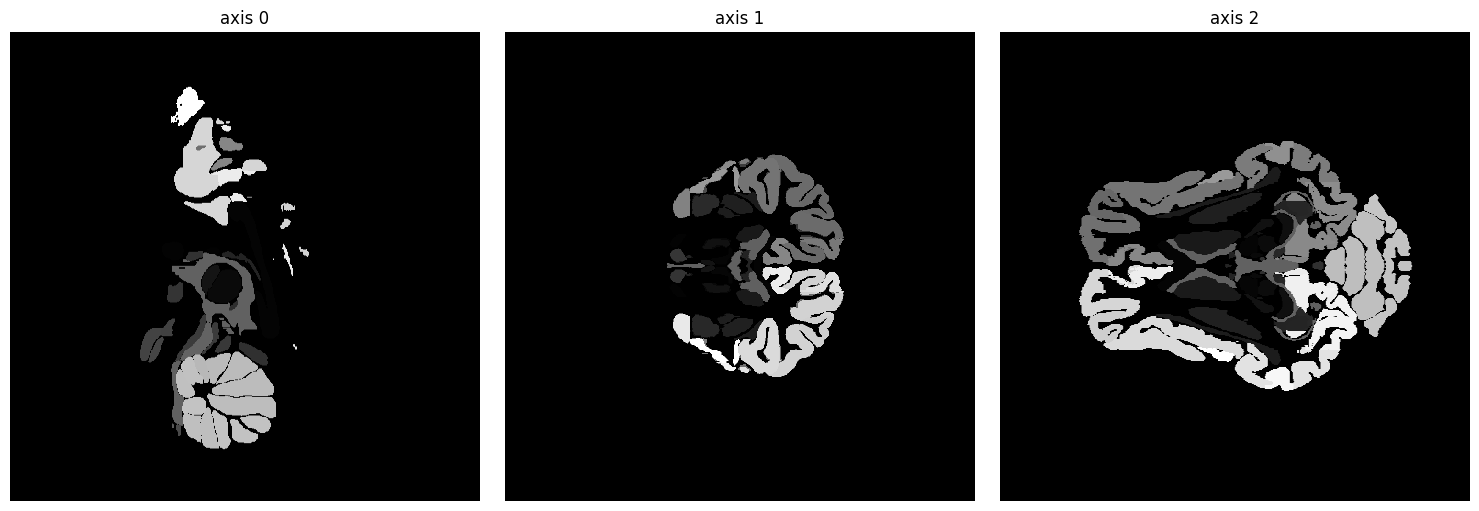

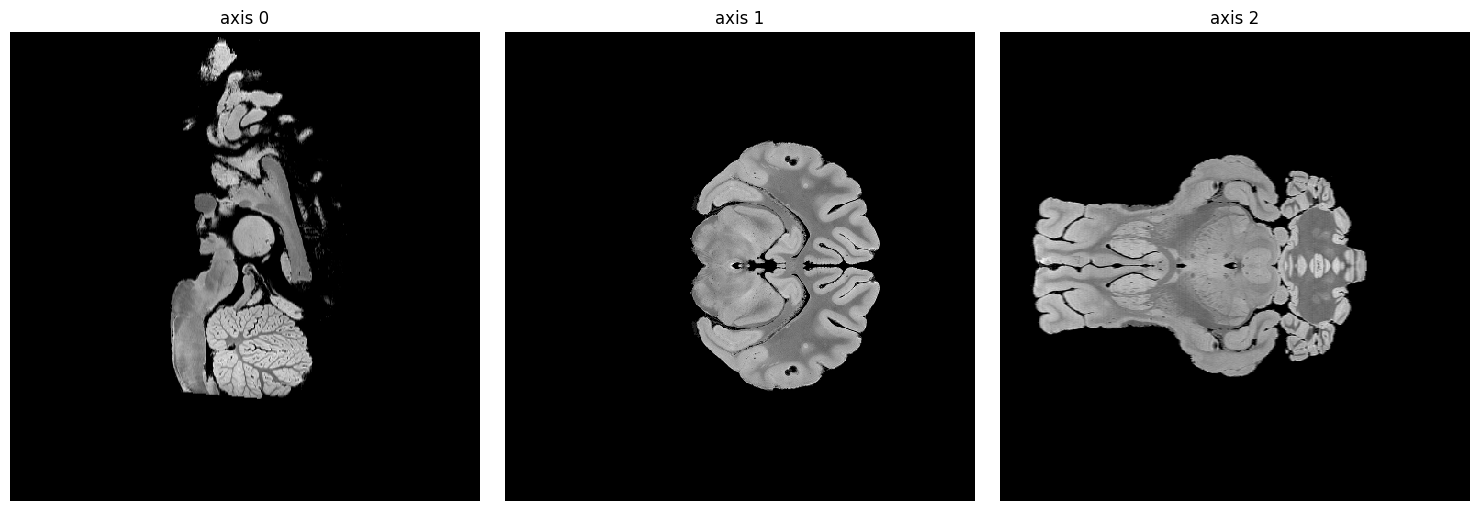

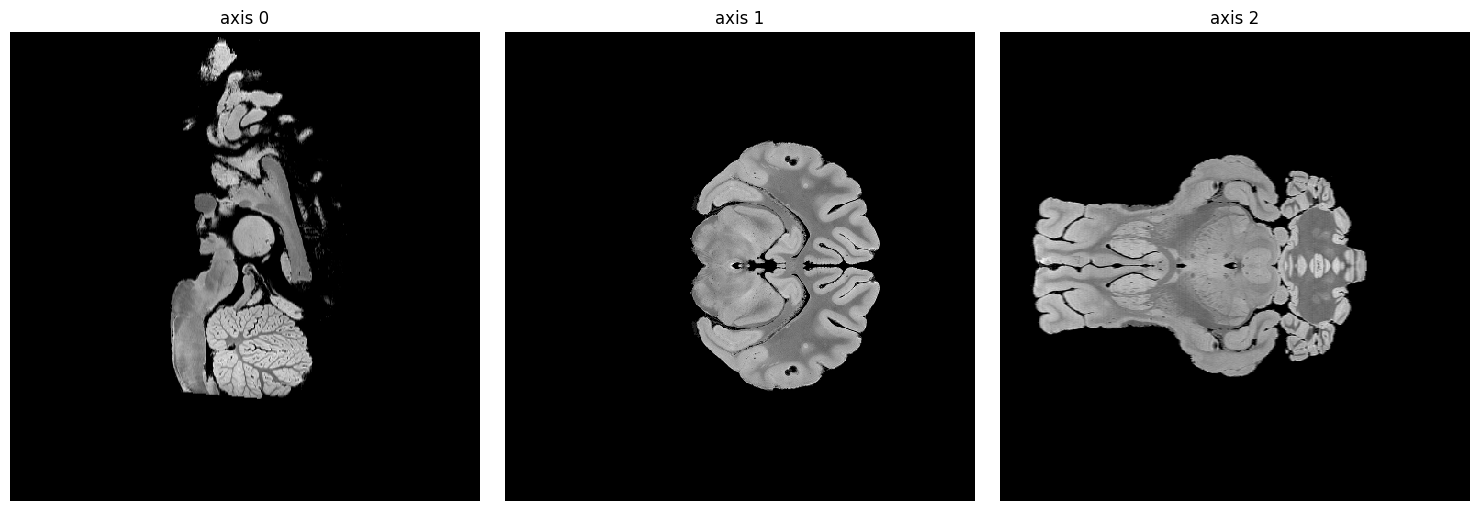

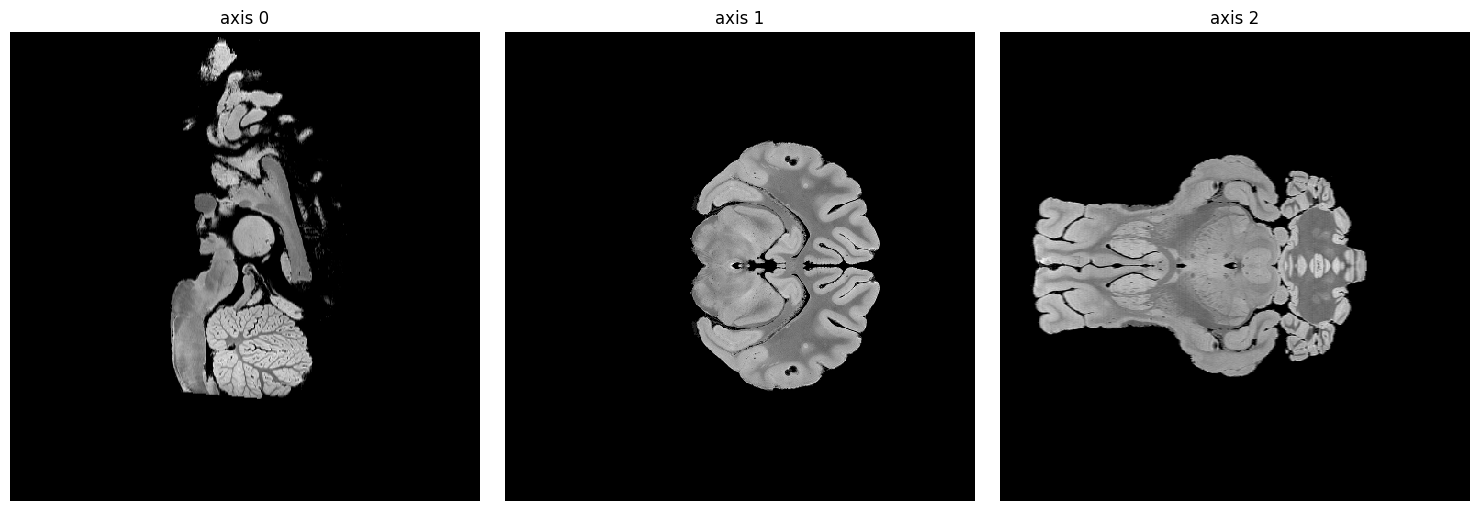

In [52]:
for i in range(4):
    one_sampe = next(gen)
    ne.plot.volume3D(one_sampe)

[DEBUG] NiftiArrayIO.load(): no header extensions found!


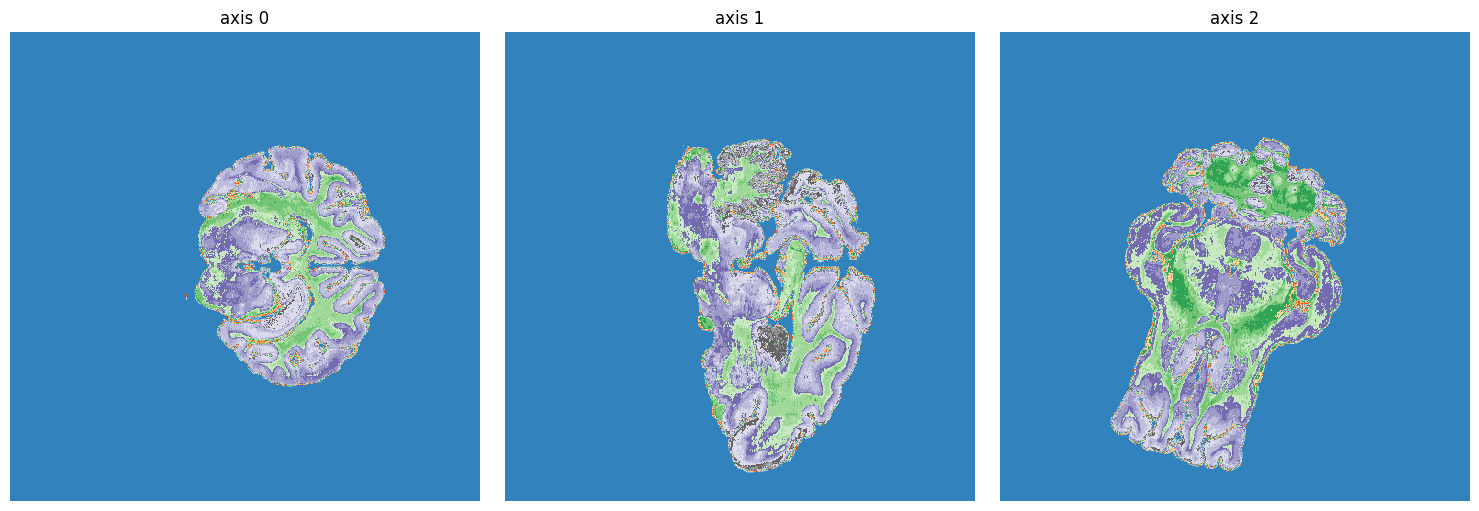

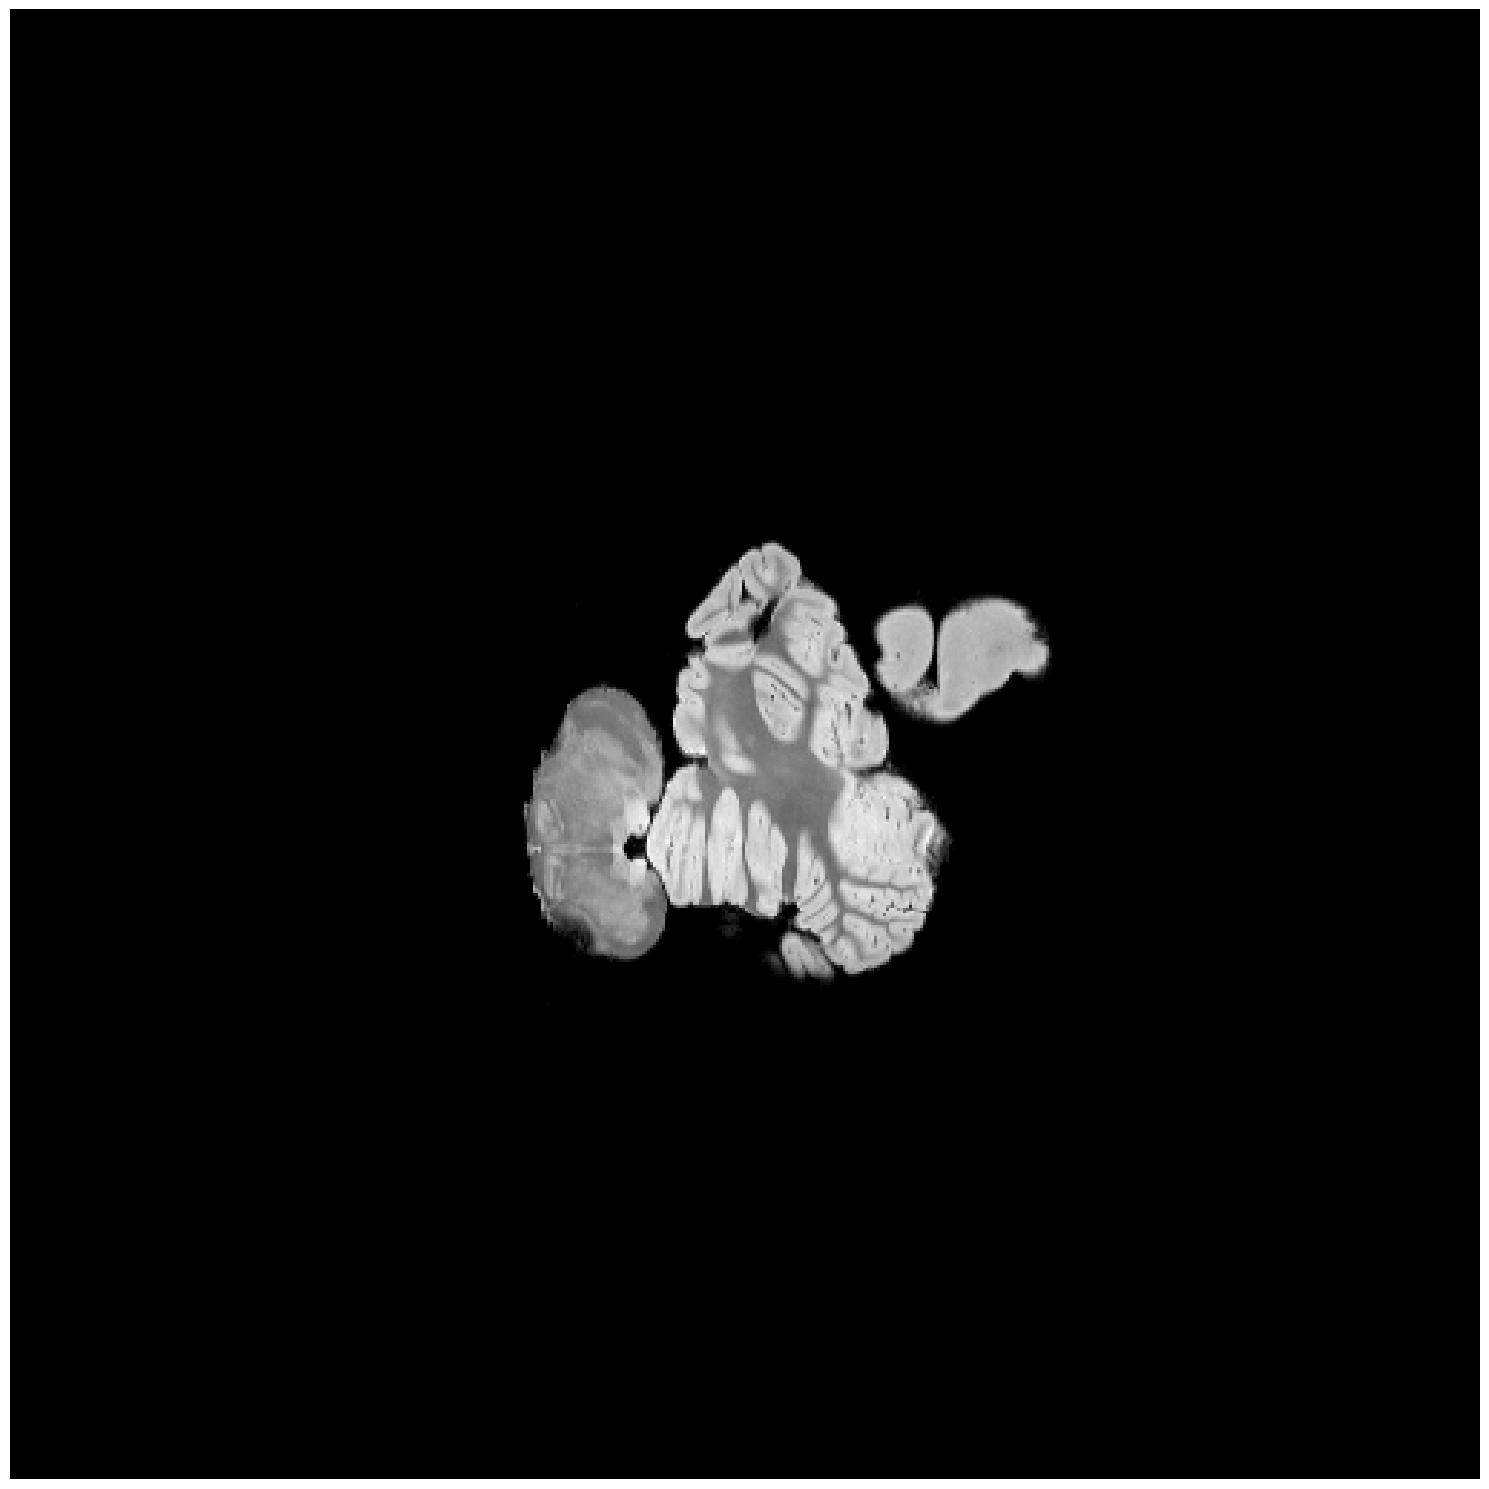

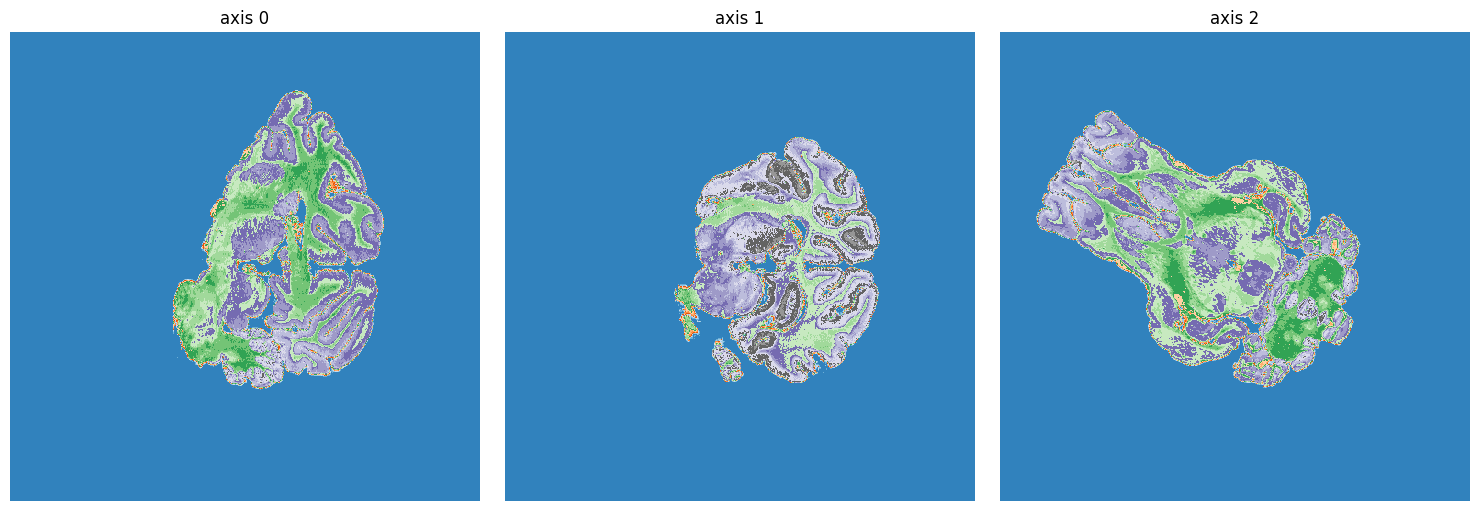

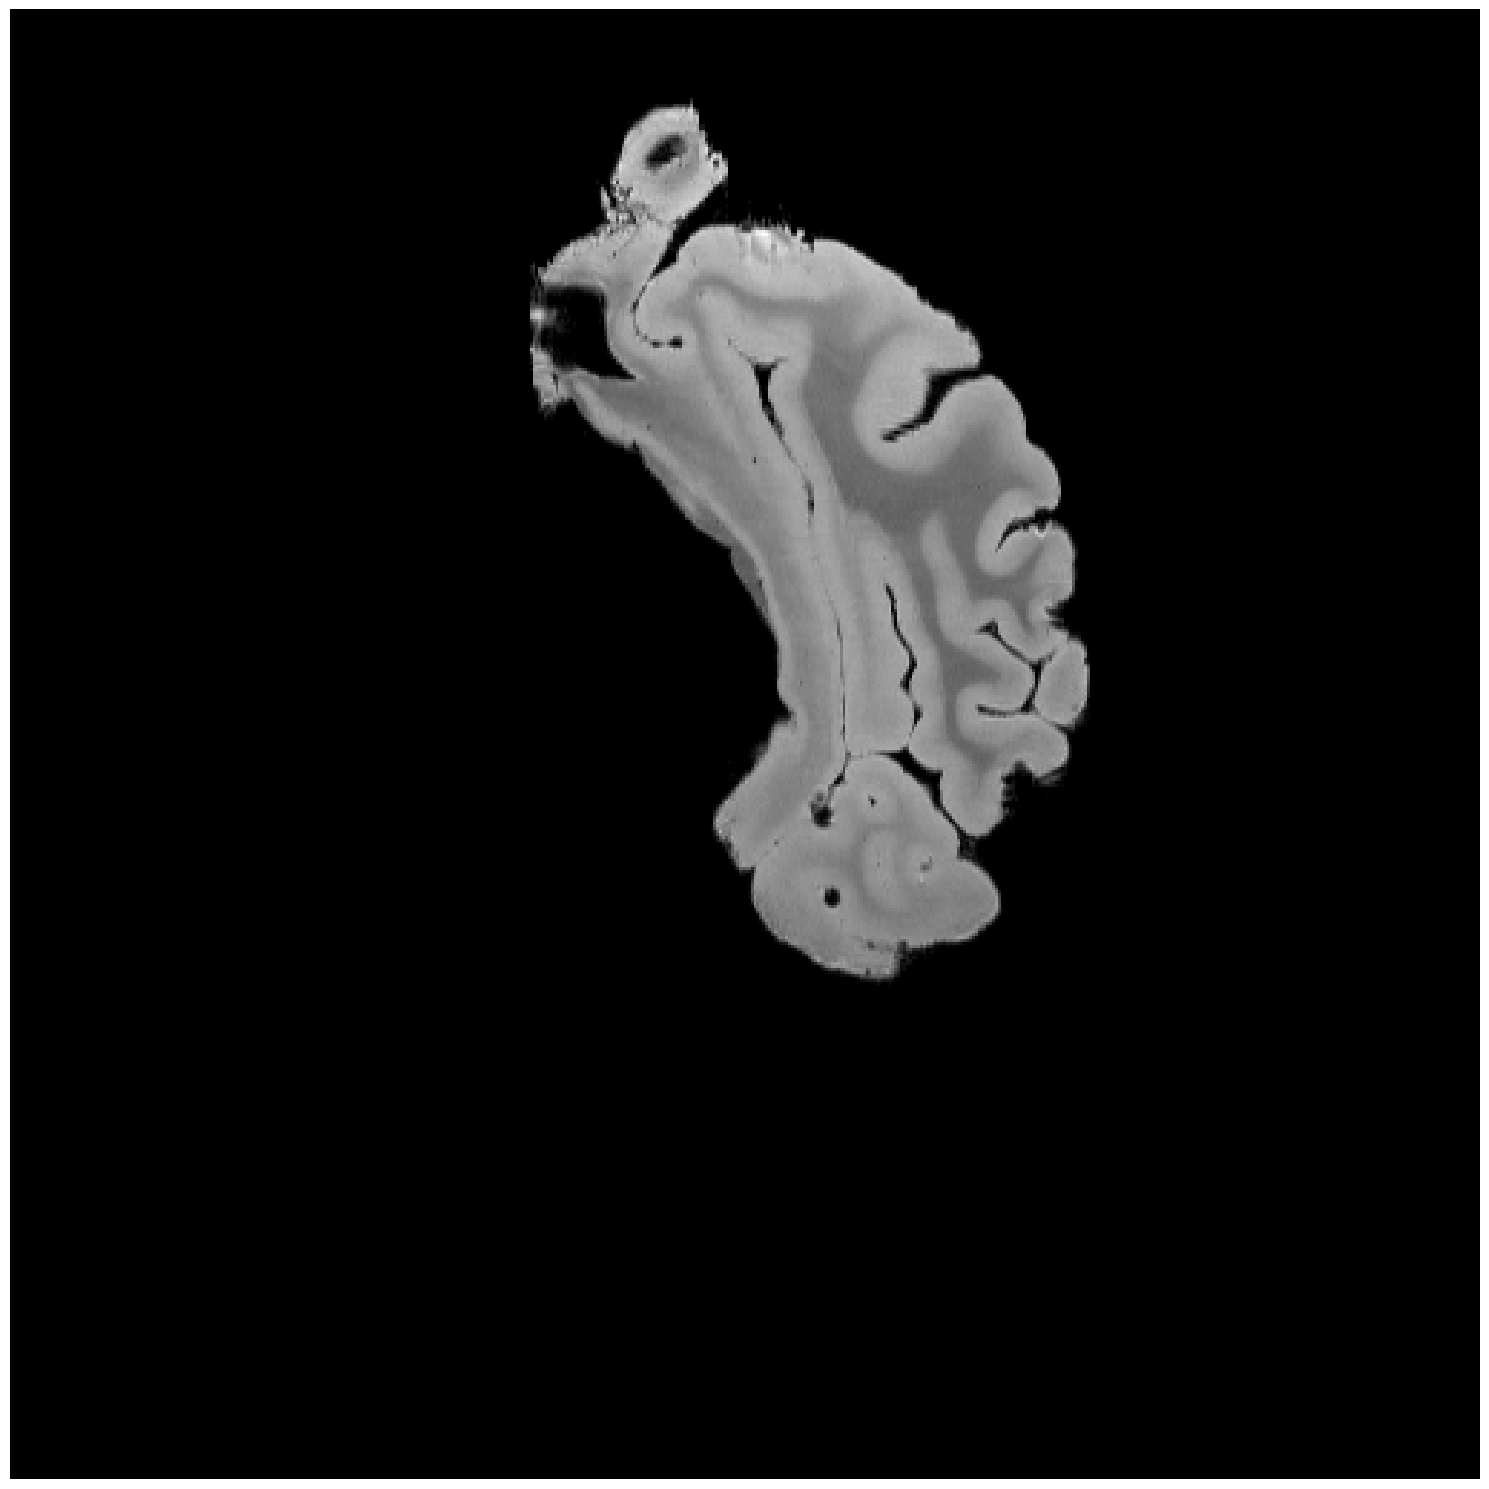

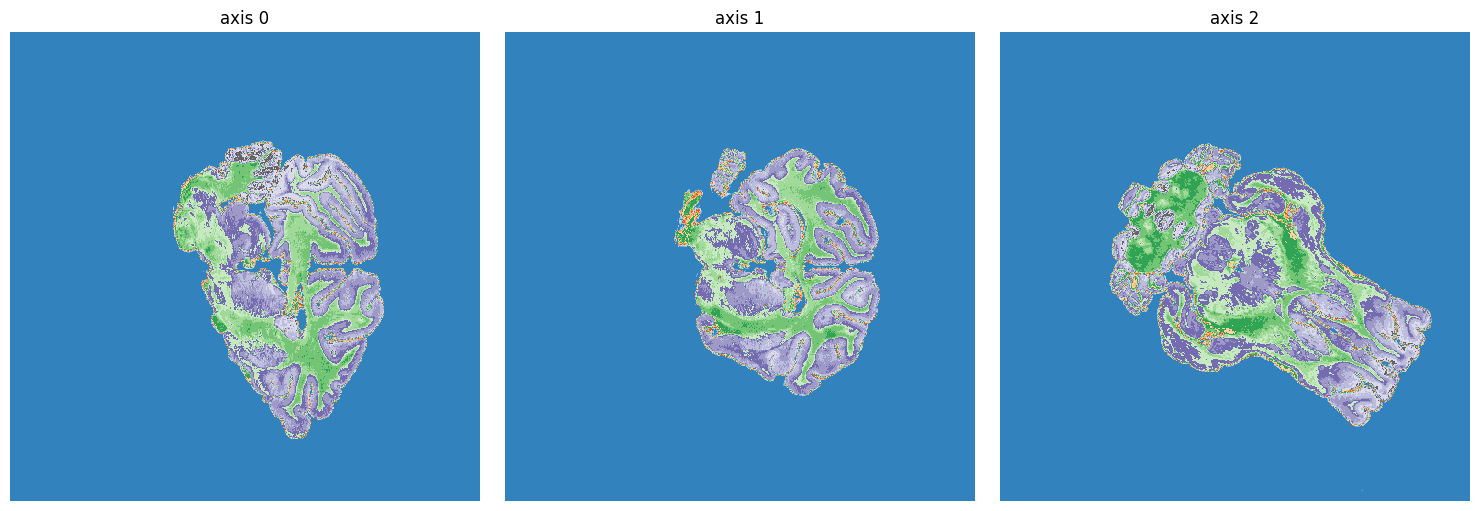

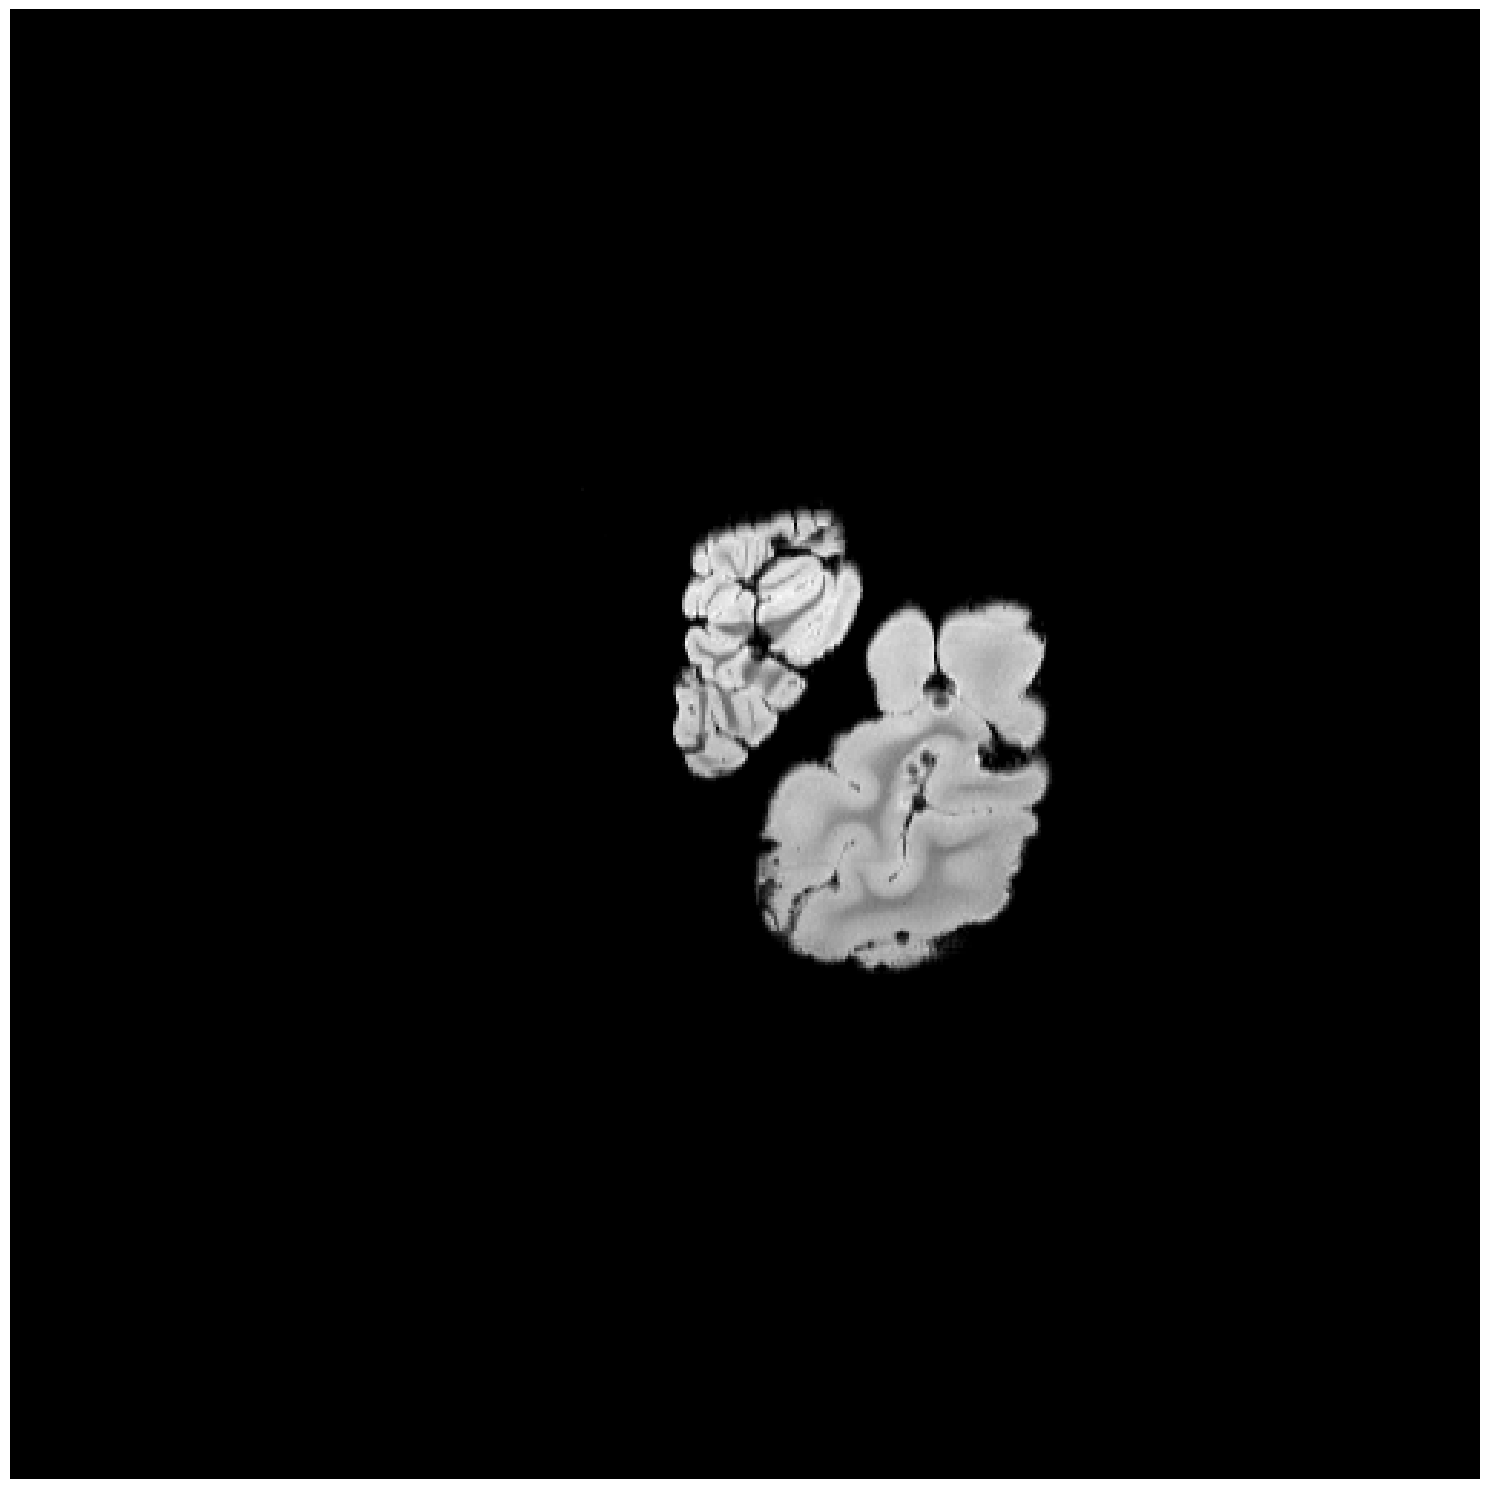

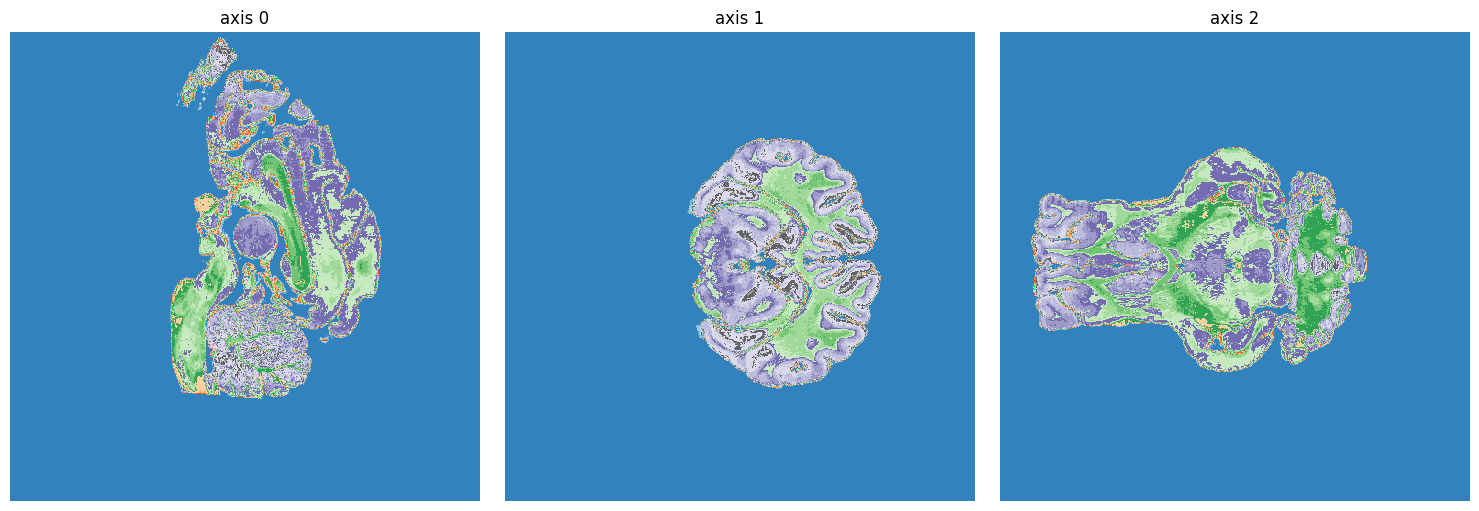

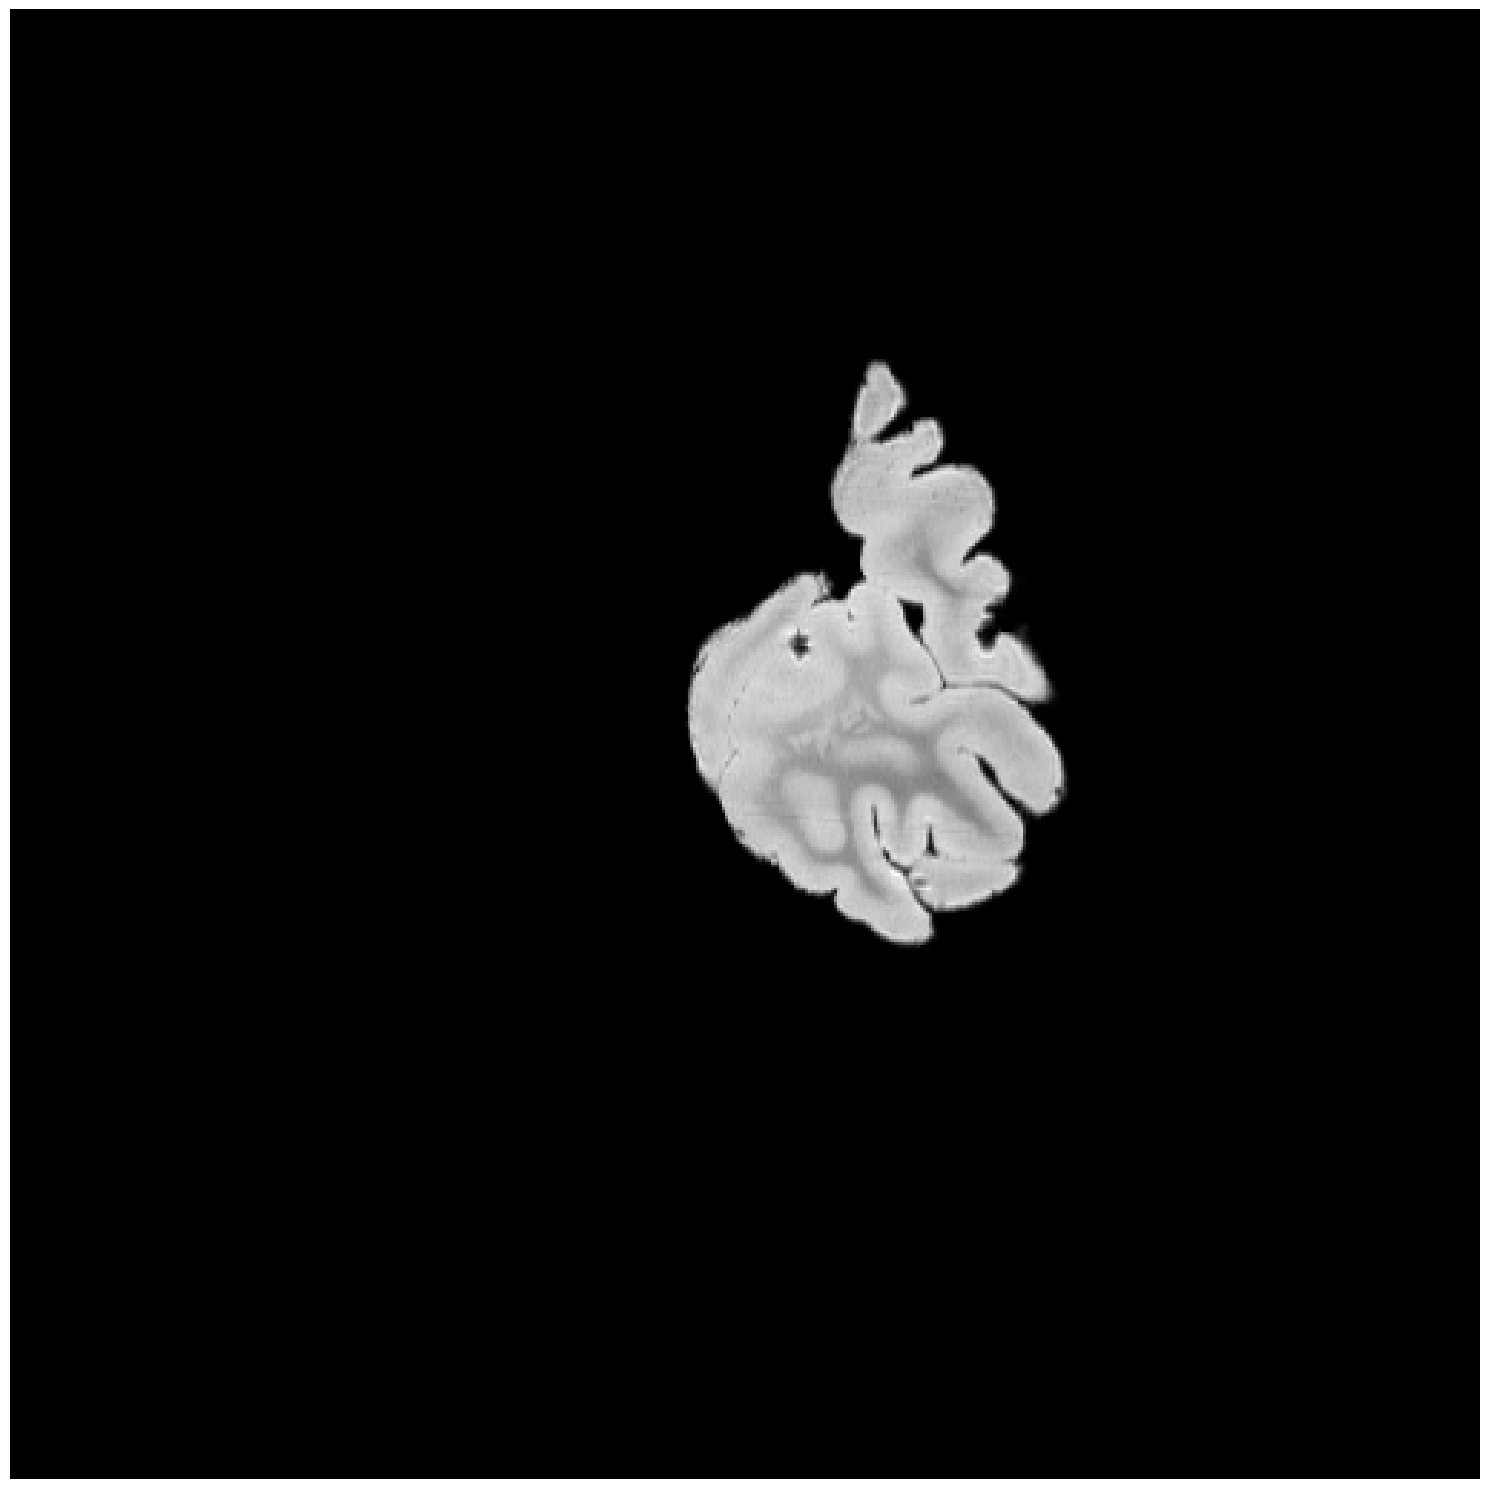

In [20]:
import numpy as np
from scipy.ndimage import rotate

def generator_Sadia_Net(label_maps, max_angle=30, keep_binary=False, seed=None):
    """
    Yields randomly rotated label maps.

    Args:
        label_maps: array-like, list/array of 2D or 3D arrays.
        max_angle: float, maximum absolute rotation in degrees (uniform in [-max_angle, +max_angle]).
        keep_binary: if True, threshold back to {0,1} after rotation (useful for masks).
        seed: optional RNG seed for reproducibility.
    """
    rng = np.random.default_rng(seed)
    label_maps = np.asarray(label_maps)

    while True:
        fg = rng.choice(label_maps)
        angle = rng.uniform(-max_angle, max_angle)

        if fg.ndim == 3:
            # choose a random rotation plane
            axes_choices = [(0, 1), (0, 2), (1, 2)]
            axes = axes_choices[rng.integers(0, len(axes_choices))]
            # order=0 preserves labels for masks; change to 1 if you're rotating images
            fg_rot = rotate(fg, angle, axes=axes, reshape=False, order=0 if keep_binary else 1,
                            mode='nearest')
        else:
            fg_rot = rotate(fg, angle, reshape=False, order=0 if keep_binary else 1,
                            mode='nearest')

        if keep_binary:
            # ensure strict 0/1 after interpolation
            fg_rot = (fg_rot > 0.5).astype(fg.dtype)

        yield fg_rot


ghost = sf.load_volume("/gpfs/fs001/cbica/home/afreens/PIG_TBI/ATLASES/ghost.nii.gz").resize(0.2).reshape((512,512,512))

label_maps=[np.array(ghost)]
gen = generator_Sadia_Net(label_maps,max_angle=180)
for i in range(4):
    one_sampe = next(gen)
    ne.plot.volume3D(one_sampe,cmaps=['tab20c'])
    # for i in range(140,145,5):
    #     ne.plot.slices(one_sampe[i,:,:],cmaps=['gray'])
    ne.plot.slices(one_sampe[145,:,:],cmaps=['gray'])
    # ne.plot.volume3D(one_sampe)
    


In [54]:
atlas.shape

(512, 512, 512)